# **General Prep**

In [1]:
#pip install pingouin

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import mixedlm, ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg
import warnings
import os
from scipy.stats import zscore, levene, ks_2samp, kruskal


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# Set a modern style
plt.style.use('seaborn-v0_8-pastel')

In [3]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)

In [4]:
# Set the working directory dynamically
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.abspath(os.path.join(notebook_dir, '..', '..', '..'))
study3_dir = os.path.join(project_root, 'study3')
os.chdir(study3_dir)

# Print current directory
print(f"Current working directory: {os.getcwd()}")

Current working directory: c:\Users\Ryo\OneDrive\Desktop\Master Thesis\master_thesis\study3


# **Data Preparation**

## prep for the response df

In [5]:
file_loc = 'raw/Study3 - final_July_18_2024_02_35_final.xlsx'
df = pd.read_excel(file_loc)
df

,ResponseId,Ads_OP_1_Reversed,Ads_OP_2_Reversed,Ads_OP_3_Reversed,Ads_OP_4_Reversed,Ads_OP_5_Reversed,Ads_OP_6_Reversed,Ads_CO_1_Normal,Ads_CO_2_Normal,Ads_CO_3_Normal,Ads_CO_4_Normal,Ads_CO_5_Normal,Ads_CO_6_Normal,Ads_EX_1_Reversed,Ads_EX_2_Reversed,Ads_EX_3_Reversed,Ads_EX_4_Reversed,Ads_EX_5_Reversed,Ads_EX_6_Reversed,Ads_AG_1_Normal,Ads_AG_2_Normal,Ads_AG_3_Normal,Ads_AG_4_Normal,Ads_AG_5_Normal,Ads_AG_6_Normal,Desc_OP_1_Normal,Desc_CO_1_Reversed,Desc_EX_1_Normal,Desc_AG_1_Reversed
0,r67,22,19,14,16,17,15,21,22,18,18,18,15,24,25,23,22,21,17,70,69,69,68,65,61,75,26,75,22
1,r13,28,50,47,72,50,41,34,50,50,59,46,21,46,50,58,62,55,38,56,50,55,64,58,60,91,90,80,40
2,r23,10,10,10,10,10,10,0,0,0,0,0,0,10,10,10,10,10,10,61,60,61,61,61,62,100,100,100,42
3,r41,60,50,63,90,90,89,31,50,34,50,39,37,62,50,65,80,70,79,62,50,54,67,67,77,82,82,82,34
4,r102,80,50,90,85,90,85,80,50,75,50,75,87,95,50,95,50,95,95,70,60,70,67,70,70,10,80,60,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,r75,82,64,86,72,79,90,40,44,24,37,31,15,39,31,21,21,13,13,81,73,91,68,81,89,20,70,83,32
88,r119,88,86,92,83,86,85,28,41,11,28,28,16,81,78,87,81,75,86,68,66,70,61,70,66,76,26,68,30
89,r18,37,33,35,49,47,46,61,56,67,53,74,86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
90,r17,53,52,70,62,75,82,35,49,28,40,31,33,69,69,77,64,69,68,53,54,55,51,50,50,51,52,53,53


In [6]:
print(f"shape {df.shape}")

shape (92, 29)


In [7]:
file_loc = 'raw/20240721_prolific_export.csv'
target_respondants = pd.read_csv(file_loc)
target_respondants = target_respondants[target_respondants['Status'] == 'APPROVED']['Participant id'].unique().tolist()
len(target_respondants)

90

In [8]:
study3_respondants = df['ResponseId'].tolist()
print(f"original respondse counts: {len(study3_respondants)}")

# filter df to target participants
# Count non-null values for each row
df['non_null_count'] = df.notna().sum(axis=1)

# Sort by 'ResponseId' and 'non_null_count' (descending), then drop duplicates
df = df.sort_values(['ResponseId', 'non_null_count'], ascending=[True, False]).drop_duplicates('ResponseId')

# Remove the temporary 'non_null_count' column
df = df.drop('non_null_count', axis=1)

# Filter to keep only target respondents
s3_response_df = df[df['ResponseId'].isin(target_respondants)]
print(f"final respondse counts: {len(s3_response_df['ResponseId'])}")


original respondse counts: 92
final respondse counts: 90


In [9]:
# Reverse scores for columns ending with '_Reversed'
reversed_columns = [col for col in s3_response_df.columns if col.endswith('_Reversed')]
for col in reversed_columns:
    s3_response_df[col] = 100 - s3_response_df[col]

# Remove '_Normal' or '_Reversed' from all column names
s3_response_df.columns = s3_response_df.columns.str.replace('_Normal', '').str.replace('_Reversed', '')

# Display the modified DataFrame
s3_response_df

,ResponseId,Ads_OP_1,Ads_OP_2,Ads_OP_3,Ads_OP_4,Ads_OP_5,Ads_OP_6,Ads_CO_1,Ads_CO_2,Ads_CO_3,Ads_CO_4,Ads_CO_5,Ads_CO_6,Ads_EX_1,Ads_EX_2,Ads_EX_3,Ads_EX_4,Ads_EX_5,Ads_EX_6,Ads_AG_1,Ads_AG_2,Ads_AG_3,Ads_AG_4,Ads_AG_5,Ads_AG_6,Desc_OP_1,Desc_CO_1,Desc_EX_1,Desc_AG_1
8,r100,72,62,50,56,50,81,43,22,50,37,46,35,65,67,65,50,72,89,31,29,46,40,38,21,94,91,97,92
24,r101,35,45,45,25,45,49,30,40,30,20,20,0,25,40,20,15,30,10,20,40,30,21,10,20,85,70,70,20
4,r102,20,50,10,15,10,15,80,50,75,50,75,87,5,50,5,50,5,5,70,60,70,67,70,70,10,20,60,20
23,r103,78,91,90,94,78,84,14,21,16,15,8,4,87,86,84,85,83,88,88,93,92,96,82,82,79,6,23,24
60,r104,20,20,20,20,20,20,10,10,10,10,10,10,20,20,20,20,20,20,10,10,10,10,10,10,95,95,95,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,r93,3,50,47,34,50,50,37,59,50,39,22,11,100,33,21,36,75,75,68,73,96,50,53,70,0,19,91,25
44,r95,60,70,65,64,55,67,45,40,41,30,31,37,81,85,76,76,68,71,70,58,71,75,63,76,40,76,80,45
11,r96,17,30,21,8,14,9,78,68,75,0,73,91,23,30,4,38,22,22,36,73,81,0,91,41,74,14,69,30
5,r97,15,10,8,16,14,11,93,89,89,95,89,93,14,11,4,11,9,5,9,17,5,10,8,9,20,87,88,84


## prep for socioecnomic and big5 scores

In [10]:
big5_file_loc = 'raw/big5_scores.csv'
big5_df = pd.read_csv(big5_file_loc)
big5_df.tail(5)

,ResponseId,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Open_Mindedness
99,r128,3.333333,3.000000,3.166667,3.666667,4.166667
100,r129,3.500000,4.833333,4.333333,1.000000,3.000000
101,r131,3.666667,4.833333,4.333333,1.166667,4.666667
102,r133,3.833333,4.000000,4.666667,1.666667,4.000000
103,r134,4.500000,4.666667,5.000000,1.333333,3.166667


In [11]:
socioecono_file_loc = 'raw/socioecono_scores.csv'
socioecono_df = pd.read_csv(socioecono_file_loc)
socioecono_df.tail(5)

,ResponseId,gender,age,education,race,employment,income
99,r128,2,27,4,2,1,1
100,r129,2,30,2,1,6,5
101,r131,2,55,5,2,9,11
102,r133,1,43,5,2,7,12
103,r134,2,43,5,2,7,8


In [12]:
# filter socioecono_df and big5_df to study3 participants
socioecono_df = socioecono_df[socioecono_df['ResponseId'].isin(target_respondants)]
big5_df = big5_df[big5_df['ResponseId'].isin(target_respondants)]
print(f"row # for socioecono_df : {len(socioecono_df['ResponseId'])}, row # for big5_df : {len(big5_df['ResponseId'])}")

row # for socioecono_df : 90, row # for big5_df : 90


## demographic analysis

In [13]:
print(f"mean age {socioecono_df['age'].mean()} with sd {socioecono_df['age'].std()}, female % {socioecono_df[socioecono_df['gender']==1]['gender'].sum()/socioecono_df.shape[0]}")

mean age 40.86666666666667 with sd 11.74466170869495, female % 0.4777777777777778


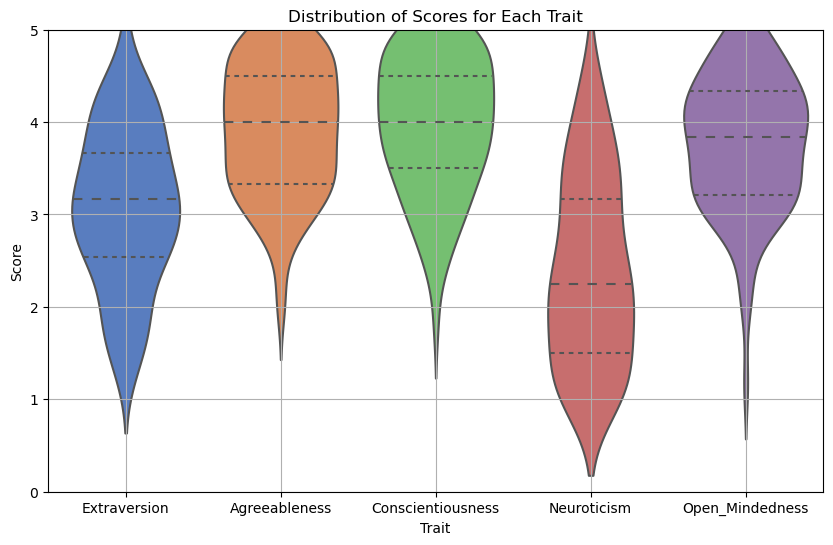

In [14]:
# Melt the DataFrame
big5_df_num = big5_df.iloc[:,1:]
big5_df_melted = big5_df_num.melt(var_name='Trait', value_name='Score')

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Trait', y='Score', data=big5_df_melted, inner='quartile', palette='muted')
plt.title('Distribution of Scores for Each Trait')
plt.ylim(0, 5)
plt.xlabel('Trait')
plt.ylabel('Score')
plt.grid(True)

# Show the plot
plt.show()

## generating distance for a single trait and blended traits

In [18]:
mixed_trait_scores = pd.read_csv('raw/mixed_trait_scores.csv')
mixed_trait_scores

,Extraversion,Agreeableness,Conscientiousness,Open_Mindedness
0,3.166667,4.0,4.0,3.833333


In [19]:
big5_dict = {'op': 'Open_Mindedness',
             'co': 'Conscientiousness',
             'ex': 'Extraversion',
             'ag': 'Agreeableness'}


In [20]:
def calculate_distance(df, mixed_scores, trait):
    trait_full = big5_dict[trait]
    return np.abs(df[trait_full] - mixed_scores[trait_full].values[0])

def calculate_distance_from_max(df, trait):
    trait_full = big5_dict[trait]
    return 5 - df[trait_full]

def generate_big5_distance_df(big5_df, mixed_trait_scores):
    distances = pd.DataFrame(index=big5_df.index)
    
    for trait in big5_dict.keys():
        distances[f'{trait}_distance'] = calculate_distance(big5_df, mixed_trait_scores, trait)
        distances[f'{trait}_distance_from_max'] = calculate_distance_from_max(big5_df, trait)
    
    distances['total_distance'] = distances[[f'{trait}_distance' for trait in big5_dict.keys()]].sum(axis=1)
    
    distance_columns = [f'{trait}_distance' for trait in big5_dict.keys()]
    distances['average_distance'] = distances[distance_columns].mean(axis=1)
    
    return pd.concat([big5_df['ResponseId'], distances], axis=1)

def generate_big5_distance_type_df(df, mixed_trait_scores):
    distances = pd.DataFrame(index=df.index)
    
    for trait in big5_dict.keys():
        distances[f'{trait}_distance'] = calculate_distance(df, mixed_trait_scores, trait)
        distances[f'{trait}_distance_from_max'] = calculate_distance_from_max(df, trait)
    
    distances['total_distance'] = distances[[f'{trait}_distance' for trait in big5_dict.keys()]].sum(axis=1)
    
    distance_columns = [f'{trait}_distance' for trait in big5_dict.keys()]
    distances['average_distance'] = distances[distance_columns].mean(axis=1)
    
    return pd.concat([df['ResponseId'], distances], axis=1)

# Generate big5_distance_df for all respondents
big5_distance_df = generate_big5_distance_df(big5_df, mixed_trait_scores)

# Generate big5_distance_{type} for each type (20240727 ceased)
"""
big5_distance_dfs_dict = {}
for type, df in big5_dfs_dict.items():
    big5_distance_dfs_dict[type] = generate_big5_distance_type_df(df, mixed_trait_scores)
    globals()[f'big5_distance_{type}'] = big5_distance_dfs_dict[type]
"""

# Display summary statistics for the comprehensive DataFrame
print("Summary for all responses:")
print(big5_distance_df.describe())
print("\n")

# Display top 5 closest participants based on total distance for all responses
print("Top 5 closest participants for all responses based on total distance:")
print(big5_distance_df.sort_values('total_distance').head())
print("\n" + "="*50 + "\n")

Summary for all responses:
       op_distance  op_distance_from_max  co_distance  co_distance_from_max  \
count    90.000000             90.000000    90.000000             90.000000   
mean      0.587037              1.235185     0.609259              1.038889   
std       0.440766              0.733493     0.423381              0.743700   
min       0.000000              0.000000     0.000000              0.000000   
25%       0.333333              0.666667     0.333333              0.500000   
50%       0.500000              1.166667     0.500000              1.000000   
75%       0.833333              1.791667     0.833333              1.500000   
max       2.666667              3.833333     2.166667              3.166667   

       ex_distance  ex_distance_from_max  ag_distance  ag_distance_from_max  \
count    90.000000             90.000000    90.000000             90.000000   
mean      0.694444              1.920370     0.585185              1.081481   
std       0.509124      

<Axes: >

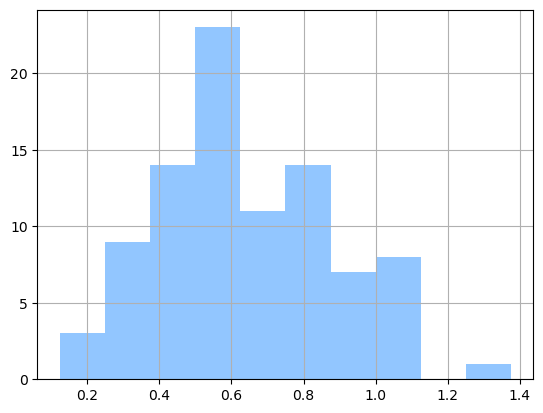

In [21]:
big5_distance_df['average_distance'].hist()

## Introduce a merged_df

All recorded by ResponseId
- **s3_response_df**   : has all of the 0 - 100 scale scores from the survey
- **big5_distance_df** : (1) distances for each trait from the benchmark scores(median) of a blended personality.  (2) distances for each trait from the max score(=5). (3) total and average distances from the benchmark scores of a blended personality
- **socioecono_df**    : socio economic scores

In [22]:
big5_distance_df.head(1)

,ResponseId,op_distance,op_distance_from_max,co_distance,co_distance_from_max,ex_distance,ex_distance_from_max,ag_distance,ag_distance_from_max,total_distance,average_distance
1,r12,0.333333,0.833333,0.166667,0.833333,0.666667,1.166667,0.833333,1.833333,2.0,0.5


In [23]:
s3_response_df.head(1)

,ResponseId,Ads_OP_1,Ads_OP_2,Ads_OP_3,Ads_OP_4,Ads_OP_5,Ads_OP_6,Ads_CO_1,Ads_CO_2,Ads_CO_3,Ads_CO_4,Ads_CO_5,Ads_CO_6,Ads_EX_1,Ads_EX_2,Ads_EX_3,Ads_EX_4,Ads_EX_5,Ads_EX_6,Ads_AG_1,Ads_AG_2,Ads_AG_3,Ads_AG_4,Ads_AG_5,Ads_AG_6,Desc_OP_1,Desc_CO_1,Desc_EX_1,Desc_AG_1
8,r100,72,62,50,56,50,81,43,22,50,37,46,35,65,67,65,50,72,89,31,29,46,40,38,21,94,91,97,92


In [24]:
# Merge big5_distance_df, s3_response_df, and socioecono_df on ResponseId
merged_df = pd.merge(big5_distance_df, s3_response_df, on='ResponseId', how='inner')
merged_df = pd.merge(merged_df, socioecono_df, on='ResponseId', how='inner')

# Rename columns in the merged dataframe
column_mapping = {
    'op_distance': 'OP_distance',
    'op_distance_from_max': 'OP_distance_from_max',
    'co_distance': 'CO_distance',
    'co_distance_from_max': 'CO_distance_from_max',
    'ex_distance': 'EX_distance',
    'ex_distance_from_max': 'EX_distance_from_max',
    'ag_distance': 'AG_distance',
    'ag_distance_from_max': 'AG_distance_from_max'
}

merged_df = merged_df.rename(columns=column_mapping)

# Display the column names to verify the changes
print("\nColumn names:")
print(merged_df.columns)



Column names:
Index(['ResponseId', 'OP_distance', 'OP_distance_from_max', 'CO_distance',
       'CO_distance_from_max', 'EX_distance', 'EX_distance_from_max',
       'AG_distance', 'AG_distance_from_max', 'total_distance',
       'average_distance', 'Ads_OP_1', 'Ads_OP_2', 'Ads_OP_3', 'Ads_OP_4',
       'Ads_OP_5', 'Ads_OP_6', 'Ads_CO_1', 'Ads_CO_2', 'Ads_CO_3', 'Ads_CO_4',
       'Ads_CO_5', 'Ads_CO_6', 'Ads_EX_1', 'Ads_EX_2', 'Ads_EX_3', 'Ads_EX_4',
       'Ads_EX_5', 'Ads_EX_6', 'Ads_AG_1', 'Ads_AG_2', 'Ads_AG_3', 'Ads_AG_4',
       'Ads_AG_5', 'Ads_AG_6', 'Desc_OP_1', 'Desc_CO_1', 'Desc_EX_1',
       'Desc_AG_1', 'gender', 'age', 'education', 'race', 'employment',
       'income'],
      dtype='object')


introduce normalized merged_df

array([[<Axes: title={'center': 'OP_distance'}>,
        <Axes: title={'center': 'OP_distance_from_max'}>,
        <Axes: title={'center': 'CO_distance'}>],
       [<Axes: title={'center': 'CO_distance_from_max'}>,
        <Axes: title={'center': 'EX_distance'}>,
        <Axes: title={'center': 'EX_distance_from_max'}>],
       [<Axes: title={'center': 'AG_distance'}>,
        <Axes: title={'center': 'AG_distance_from_max'}>,
        <Axes: title={'center': 'total_distance'}>],
       [<Axes: title={'center': 'average_distance'}>, <Axes: >, <Axes: >]],
      dtype=object)

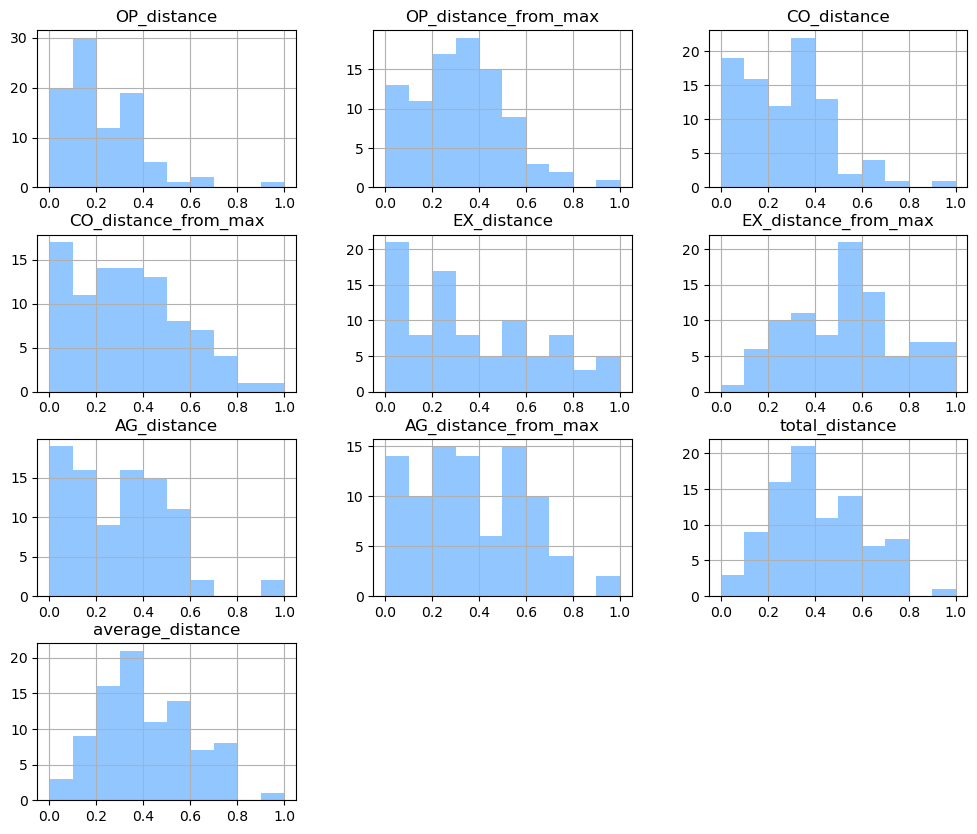

In [25]:
# Define the columns to normalize
columns_to_normalize = [
    'OP_distance', 'OP_distance_from_max', 'CO_distance', 'CO_distance_from_max',
    'EX_distance', 'EX_distance_from_max', 'AG_distance', 'AG_distance_from_max',
    'total_distance', 'average_distance'
]

# Create a new DataFrame with normalized columns
merged_df_norm = merged_df.copy()

# Normalize the specified columns
for column in columns_to_normalize:
    merged_df_norm[column] = (merged_df_norm[column] - merged_df_norm[column].min()) / (merged_df_norm[column].max() - merged_df_norm[column].min())

merged_df_norm[columns_to_normalize].hist(figsize= (12,10))


In [26]:
merged_df.head(1)

,ResponseId,OP_distance,OP_distance_from_max,CO_distance,CO_distance_from_max,EX_distance,EX_distance_from_max,AG_distance,AG_distance_from_max,total_distance,average_distance,Ads_OP_1,Ads_OP_2,Ads_OP_3,Ads_OP_4,Ads_OP_5,Ads_OP_6,Ads_CO_1,Ads_CO_2,Ads_CO_3,Ads_CO_4,Ads_CO_5,Ads_CO_6,Ads_EX_1,Ads_EX_2,Ads_EX_3,Ads_EX_4,Ads_EX_5,Ads_EX_6,Ads_AG_1,Ads_AG_2,Ads_AG_3,Ads_AG_4,Ads_AG_5,Ads_AG_6,Desc_OP_1,Desc_CO_1,Desc_EX_1,Desc_AG_1,gender,age,education,race,employment,income
0,r12,0.333333,0.833333,0.166667,0.833333,0.666667,1.166667,0.833333,1.833333,2.0,0.5,89,75,89,84,71,75,81,66,74,77,79,82,72,68,67,68,76,69,71,78,70,68,85,84,63,50,53,50,1,36,5,1,7,7


In [27]:
merged_df_norm.head(1)

,ResponseId,OP_distance,OP_distance_from_max,CO_distance,CO_distance_from_max,EX_distance,EX_distance_from_max,AG_distance,AG_distance_from_max,total_distance,average_distance,Ads_OP_1,Ads_OP_2,Ads_OP_3,Ads_OP_4,Ads_OP_5,Ads_OP_6,Ads_CO_1,Ads_CO_2,Ads_CO_3,Ads_CO_4,Ads_CO_5,Ads_CO_6,Ads_EX_1,Ads_EX_2,Ads_EX_3,Ads_EX_4,Ads_EX_5,Ads_EX_6,Ads_AG_1,Ads_AG_2,Ads_AG_3,Ads_AG_4,Ads_AG_5,Ads_AG_6,Desc_OP_1,Desc_CO_1,Desc_EX_1,Desc_AG_1,gender,age,education,race,employment,income
0,r12,0.125,0.217391,0.076923,0.263158,0.363636,0.318182,0.416667,0.611111,0.3,0.3,89,75,89,84,71,75,81,66,74,77,79,82,72,68,67,68,76,69,71,78,70,68,85,84,63,50,53,50,1,36,5,1,7,7


## Further data processing

In [28]:
traits = ['EX', 'OP', 'CO', 'AG']
for trait in traits:
    merged_df[f'Desc_{trait}_relative_1'] = merged_df[f'Desc_{trait}_1'] - 50
    merged_df_norm[f'Desc_{trait}_relative_1'] = merged_df_norm[f'Desc_{trait}_1'] - 50
    for i in range(1, 7):
        merged_df[f'Ads_{trait}_relative_{i}'] = merged_df[f'Ads_{trait}_{i}'] - 50
        merged_df_norm[f'Ads_{trait}_relative_{i}'] = merged_df_norm[f'Ads_{trait}_{i}'] - 50

In [29]:
merged_df.columns

Index(['ResponseId', 'OP_distance', 'OP_distance_from_max', 'CO_distance',
       'CO_distance_from_max', 'EX_distance', 'EX_distance_from_max',
       'AG_distance', 'AG_distance_from_max', 'total_distance',
       'average_distance', 'Ads_OP_1', 'Ads_OP_2', 'Ads_OP_3', 'Ads_OP_4',
       'Ads_OP_5', 'Ads_OP_6', 'Ads_CO_1', 'Ads_CO_2', 'Ads_CO_3', 'Ads_CO_4',
       'Ads_CO_5', 'Ads_CO_6', 'Ads_EX_1', 'Ads_EX_2', 'Ads_EX_3', 'Ads_EX_4',
       'Ads_EX_5', 'Ads_EX_6', 'Ads_AG_1', 'Ads_AG_2', 'Ads_AG_3', 'Ads_AG_4',
       'Ads_AG_5', 'Ads_AG_6', 'Desc_OP_1', 'Desc_CO_1', 'Desc_EX_1',
       'Desc_AG_1', 'gender', 'age', 'education', 'race', 'employment',
       'income', 'Desc_EX_relative_1', 'Ads_EX_relative_1',
       'Ads_EX_relative_2', 'Ads_EX_relative_3', 'Ads_EX_relative_4',
       'Ads_EX_relative_5', 'Ads_EX_relative_6', 'Desc_OP_relative_1',
       'Ads_OP_relative_1', 'Ads_OP_relative_2', 'Ads_OP_relative_3',
       'Ads_OP_relative_4', 'Ads_OP_relative_5', 'Ads_OP_relative_

## Introduce stmd_merge_df

In [30]:
# 'ResponseId'
distance_col = ['OP_distance_from_max', 
                'CO_distance_from_max', 
                'EX_distance_from_max',
                'AG_distance_from_max', 
                'average_distance']
socioecono_col = ['gender', 
                  'age', 
                  'education', 
                  'race', 
                  'employment',
                  'income']
ads_score_col = ['Ads_EX_relative_1',
                 'Ads_OP_relative_1',
                 'Ads_CO_relative_1',
                 'Ads_AG_relative_1']
desc_score_col = ['Desc_EX_relative_1',
                  'Desc_OP_relative_1',
                  'Desc_CO_relative_1',
                  'Desc_AG_relative_1']

stmd_merged_col = ['ResponseId'] + distance_col + ads_score_col + desc_score_col + socioecono_col
stmd_merged_col

['ResponseId',
 'OP_distance_from_max',
 'CO_distance_from_max',
 'EX_distance_from_max',
 'AG_distance_from_max',
 'average_distance',
 'Ads_EX_relative_1',
 'Ads_OP_relative_1',
 'Ads_CO_relative_1',
 'Ads_AG_relative_1',
 'Desc_EX_relative_1',
 'Desc_OP_relative_1',
 'Desc_CO_relative_1',
 'Desc_AG_relative_1',
 'gender',
 'age',
 'education',
 'race',
 'employment',
 'income']

In [31]:
stmd_merged_df = merged_df[stmd_merged_col]
stmd_merged_df

,ResponseId,OP_distance_from_max,CO_distance_from_max,EX_distance_from_max,AG_distance_from_max,average_distance,Ads_EX_relative_1,Ads_OP_relative_1,Ads_CO_relative_1,Ads_AG_relative_1,Desc_EX_relative_1,Desc_OP_relative_1,Desc_CO_relative_1,Desc_AG_relative_1,gender,age,education,race,employment,income
0,r12,0.833333,0.833333,1.166667,1.833333,0.500000,22,39,31,21,3,13,0,0,1,36,5,1,7,7
1,r13,1.833333,0.333333,0.833333,1.833333,0.791667,4,22,-16,6,30,41,-40,10,2,48,5,1,6,11
2,r14,0.833333,2.000000,1.833333,1.666667,0.500000,11,-21,10,15,7,-22,-1,7,2,41,4,1,5,5
3,r15,0.833333,1.500000,2.000000,0.666667,0.333333,-17,-13,14,14,15,18,12,-14,2,48,2,1,1,9
4,r16,0.000000,2.666667,1.833333,1.333333,0.791667,-34,-37,31,-30,15,-36,44,-41,2,32,4,4,5,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,r125,0.000000,0.333333,1.333333,0.666667,0.666667,43,-2,-39,-36,4,-43,-24,-3,1,47,4,6,5,2
86,r127,2.333333,1.333333,0.833333,1.500000,0.750000,-17,22,21,24,34,-29,-22,18,1,34,4,1,7,5
87,r129,2.000000,0.666667,1.500000,0.166667,0.583333,-21,-45,-26,31,-50,50,9,-39,2,30,2,1,6,5
88,r131,0.333333,0.666667,1.333333,0.166667,0.625000,-32,-32,-17,21,33,-5,-6,7,2,55,5,2,9,11


# **Analysis**

## Descriptive

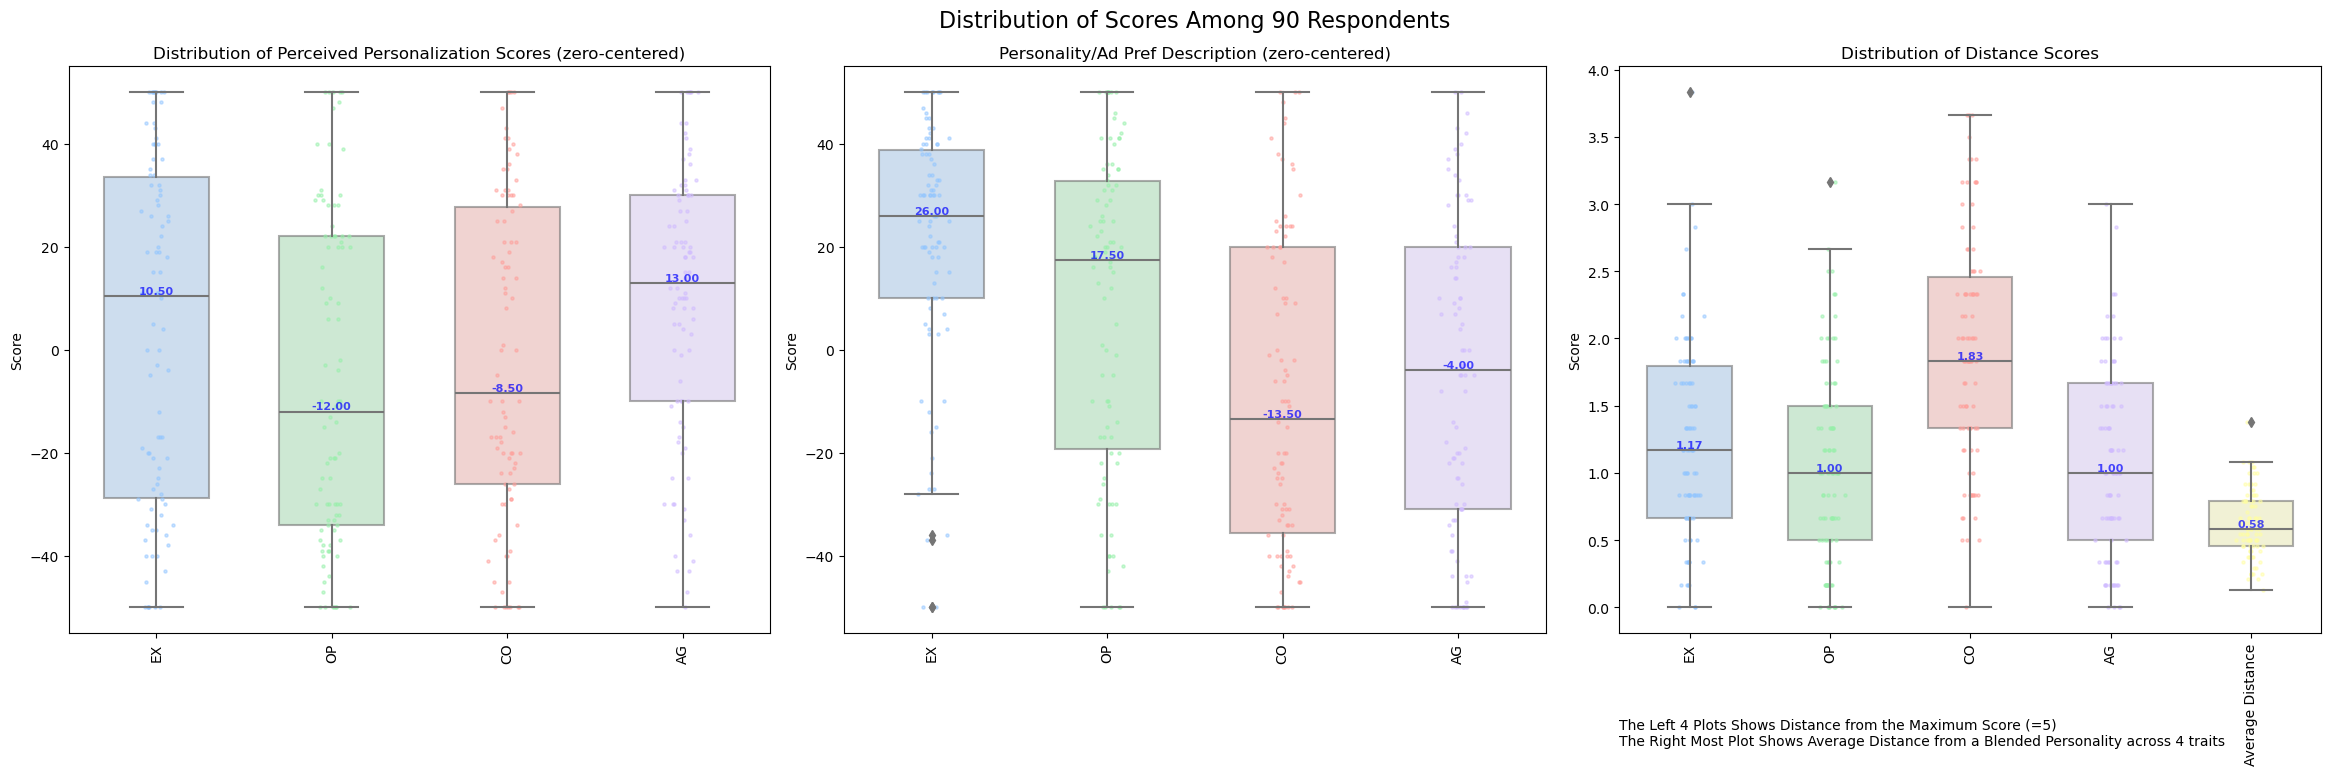

In [32]:
# Function to create boxplot with scatter and median annotation
def create_boxplot(data, columns, ax, title, xlabel_format):
    # Create boxplot
    sns.boxplot(data=data[columns], ax=ax, orient='v', width=0.6, saturation=0.5)
    
    # Set transparency for box plots
    for patch in ax.patches:
        patch.set_alpha(0.6)
    
    # Add scatter plots
    for i, col in enumerate(columns):
        x = np.random.normal(i, 0.04, size=len(data))
        ax.scatter(x, data[col], alpha=0.5, s=5)
    
    # Add median annotations
    medians = data[columns].median()
    for i, median in enumerate(medians):
        ax.text(i, median, f'{median:.2f}', 
                horizontalalignment='center', verticalalignment='bottom',
                fontweight='bold', fontsize=8, color='blue', alpha=0.7)
    
    ax.set_title(title)
    
    # Set custom x-axis labels
    ax.set_xticklabels([xlabel_format.format(trait=col.split('_')[1]) for col in columns], rotation=90)
    
    ax.set_ylabel('Score')

# Create figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('Distribution of Scores Among 90 Respondents', fontsize=16)

# Create boxplots with scatter and median annotations
create_boxplot(stmd_merged_df, ads_score_col, ax1, 
               'Distribution of Perceived Personalization Scores (zero-centered)', 
               '{trait}')

create_boxplot(stmd_merged_df, desc_score_col, ax2, 
               'Personality/Ad Pref Description (zero-centered)', 
               '{trait}')

create_boxplot(stmd_merged_df, distance_col, ax3, 
               'Distribution of Distance Scores', 
               '{trait}')

# Manually adjust the last label for average distance
ax3.set_xticklabels(['EX', 'OP', 'CO', 'AG', 'Average Distance'])

# Add annotation for explanation under the x-axis, left-aligned
ax3.annotate('The Left 4 Plots Shows Distance from the Maximum Score (=5)\nThe Right Most Plot Shows Average Distance from a Blended Personality across 4 traits',
             xy=(0, -0.15), xytext=(0, 0), xycoords='axes fraction', textcoords='offset points',
             ha='left', va='top', fontsize=10, wrap=True)

# Adjust the subplot layout to make room for the annotation
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Increase bottom margin

plt.show()

## Direct multilinear (incl. H5.1's 'Perceived Personalization' and 'Personality Description and Ad Preference')

### funciton

In [33]:
def qqplot_with_confidence(data, ax=None, dist='norm', confidence=0.95):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create Q-Q plot using Pingouin
    ax = pg.qqplot(data, dist=dist, confidence=confidence, ax=ax)
    
    # Customize the plot
    ax.set_title('Q-Q Plot with 95% Confidence Interval', fontsize=14)
    ax.set_xlabel('Theoretical Quantiles', fontsize=12)
    ax.set_ylabel('Sample Quantiles', fontsize=12)
    
    # Modify colors and styles
    for line in ax.lines:
        if line.get_linestyle() == '-':  # This is the 45-degree reference line
            line.set_color('#0000FF')
            line.set_linewidth(1.5)
        elif line.get_linestyle() == '--':  # These are the confidence interval lines
            line.set_color('lightgrey')
            line.set_linewidth(1)
    
    # Modify scatter points
    scatter = ax.collections[0]
    scatter.set_facecolor('grey')
    scatter.set_edgecolor('grey')
    scatter.set_alpha(0.7)
    
    # Remove the R² text
    # ax.texts = []
    
    # Set background grid
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.set_axisbelow(True)
    
    return ax

def check_regression_assumptions(model, X, y):
    assumption_results = {}
    
    is_ols = isinstance(model, sm.regression.linear_model.RegressionResultsWrapper)
    
    if is_ols:
        # Checks for OLS model
        # 1. Linearity (Rainbow test)
        rainbow_statistic, rainbow_p_value = linear_rainbow(model)
        assumption_results['rainbow_p_value'] = rainbow_p_value
        print(f"Rainbow test for linearity - statistic: {rainbow_statistic:.4f}, p-value: {rainbow_p_value:.4f}")
        
        # 2. Independence of errors (Durbin-Watson test)
        dw_statistic = durbin_watson(model.resid)
        assumption_results['durbin_watson'] = dw_statistic
        print(f"Durbin-Watson statistic: {dw_statistic:.4f}")
        
        # 3. Homoscedasticity (Breusch-Pagan test)
        _, pvalue, _, _ = het_breuschpagan(model.resid, model.model.exog)
        assumption_results['het_breuschpagan'] = pvalue
        print(f"Breusch-Pagan test p-value: {pvalue:.4f}")
        
        # 6. Influential outliers (Cook's distance)
        influence = OLSInfluence(model)
        cooks_d = influence.cooks_distance[0]
        assumption_results['cooks_distance'] = cooks_d
        n = len(X)
        influential = cooks_d > 4/n
        print(f"\nNumber of influential points (Cook's distance > 4/n): {sum(influential)}")
    
    # Checks applicable to both OLS and Robust Regression
    # 4. Normality of residuals (Shapiro-Wilk test)
    _, p_value = stats.shapiro(model.resid)
    assumption_results['shapiro_p_value'] = p_value
    print(f"Shapiro-Wilk test p-value: {p_value:.4f}")
    
    # Q-Q plot for normality with confidence intervals
    plt.figure(figsize=(10, 8))
    qqplot_with_confidence(model.resid)
    plt.show()
    
    # 5. Multicollinearity (VIF)
    vif_data = pd.DataFrame()
    vif_data['Variable'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    assumption_results['vif_data'] = vif_data
    print("\nVariance Inflation Factors:")
    print(vif_data)
    
    # Calculate and print max VIF
    max_vif = vif_data['VIF'].max()
    max_vif_variable = vif_data.loc[vif_data['VIF'].idxmax(), 'Variable']
    print(f"\nMaximum VIF: {max_vif:.4f} (Variable: {max_vif_variable})")
    
    return assumption_results

### analysis


Regression results for Ads_OP_relative_1:
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         23.6038     30.626      0.771      0.443     -37.343      84.551
OP_distance_from_max         -27.6645     16.599     -1.667      0.099     -60.697       5.368
average_distance             -42.0385     26.368     -1.594      0.115     -94.513      10.436
gender                        -7.0713      7.202     -0.982      0.329     -21.404       7.261
age                           -0.0348      0.287     -0.121      0.904      -0.606       0.537
education                     -4.4452      3.653     -1.217      0.227     -11.714       2.824
race                           1.3492      2.811      0.480      0.633      -4.245       6.944
employment                     0.7142      1.858      0.384      0.702      -2.983       4.411
income 

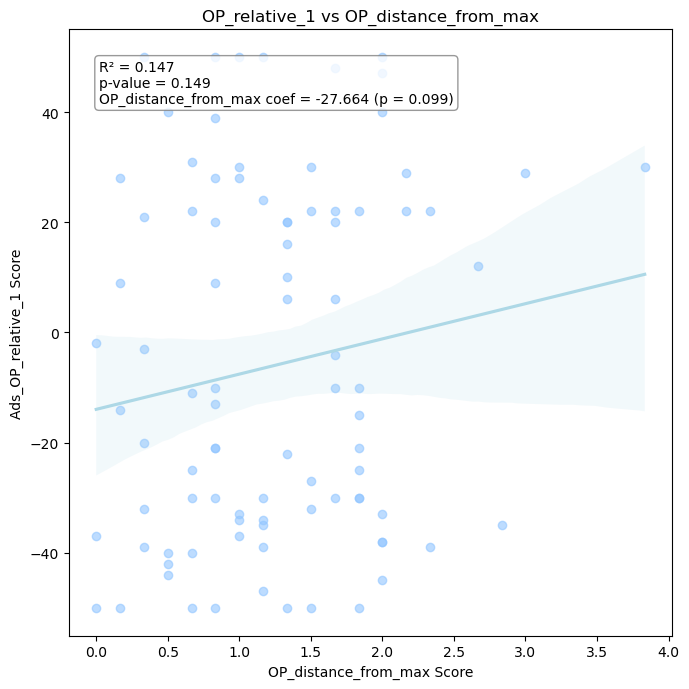


Regression results for Ads_CO_relative_1:
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         32.1071     32.808      0.979      0.331     -33.183      97.397
CO_distance_from_max           6.1435     16.050      0.383      0.703     -25.797      38.084
average_distance               8.6107     26.753      0.322      0.748     -44.629      61.850
gender                        -6.1418      7.221     -0.851      0.398     -20.511       8.228
age                           -0.3154      0.310     -1.017      0.312      -0.933       0.302
education                     -3.3199      3.672     -0.904      0.369     -10.627       3.987
race                          -3.6742      2.794     -1.315      0.192      -9.235       1.887
employment                     1.5905      1.884      0.844      0.401      -2.159       5.340
income 

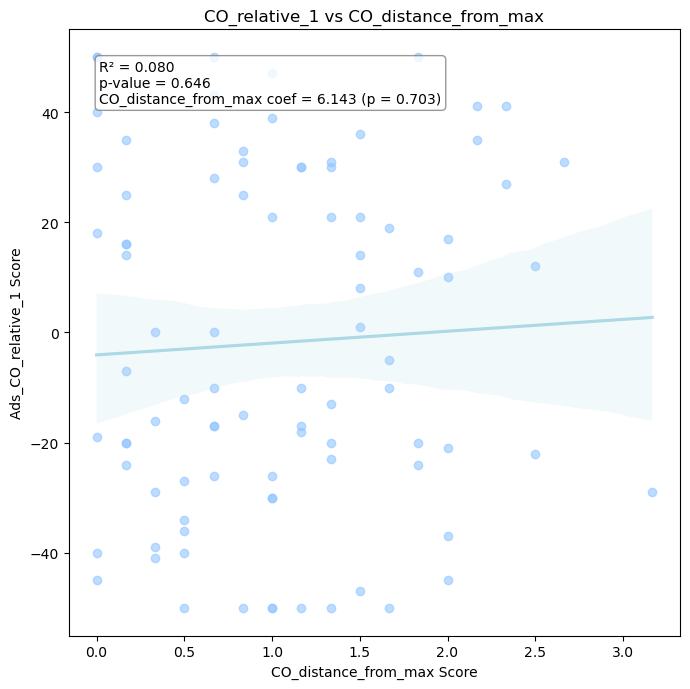


Regression results for Ads_EX_relative_1:
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -61.1156     45.106     -1.355      0.179    -150.879      28.648
EX_distance_from_max          25.0890     16.494      1.521      0.132      -7.736      57.914
average_distance              70.4924     44.102      1.598      0.114     -17.273     158.258
gender                        -4.0332      7.660     -0.527      0.600     -19.278      11.211
age                           -0.2189      0.308     -0.711      0.479      -0.832       0.394
education                      0.6297      3.898      0.162      0.872      -7.128       8.387
race                          -0.0485      2.945     -0.016      0.987      -5.909       5.812
employment                     0.5376      1.955      0.275      0.784      -3.352       4.427
income 

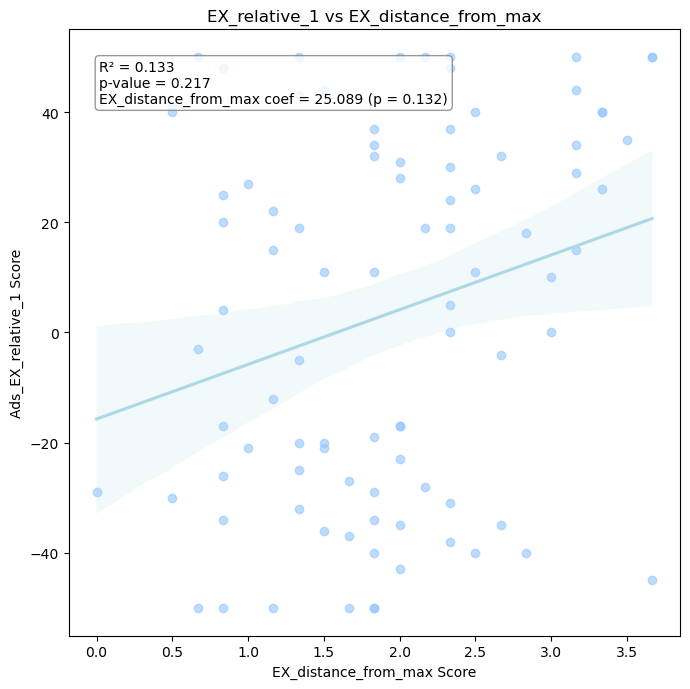


Regression results for Ads_AG_relative_1:
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         18.2008     24.096      0.755      0.452     -29.752      66.153
AG_distance_from_max          -6.9412     12.667     -0.548      0.585     -32.150      18.267
average_distance               1.6335     22.623      0.072      0.943     -43.388      46.655
gender                        -9.6263      6.215     -1.549      0.125     -21.994       2.741
age                           -0.0002      0.252     -0.001      1.000      -0.502       0.502
education                      3.2625      3.142      1.038      0.302      -2.989       9.514
race                          -3.0132      2.374     -1.269      0.208      -7.738       1.712
employment                    -1.1256      1.620     -0.695      0.489      -4.350       2.099
income 

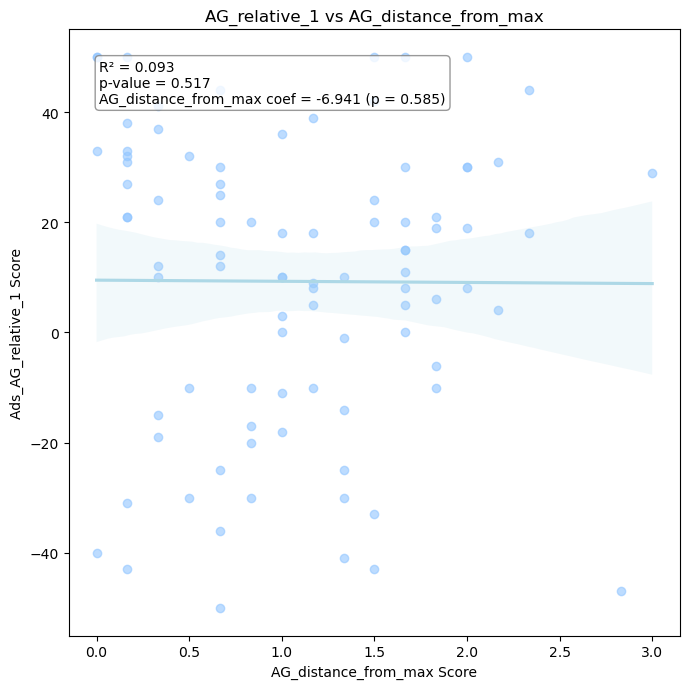

In [34]:
# (DV)         {trait type}_distance_from_max, 
# (primary IV) Ads_{trait type}_relative_1 

traits = ['OP', 'CO', 'EX', 'AG']

for trait in traits:
    # Prepare the data
    X = stmd_merged_df[['{}_distance_from_max'.format(trait), 
                        'average_distance', 
                        'gender', 'age', 'education', 
                        'race', 'employment', 'income']]
    y = stmd_merged_df['Ads_{}_relative_1'.format(trait)]

    # Add interaction term
    X['{}_distance_x_avg_distance'.format(trait)] = X['{}_distance_from_max'.format(trait)] * X['average_distance']
    
    # Add constant term to the features
    X = sm.add_constant(X)
    
    # Fit the model
    model = sm.OLS(y, X).fit()
    
    # Print the summary
    print(f"\nRegression results for Ads_{trait}_relative_1:")
    print(model.summary().tables[1])
    
    # Create scatter plot
    plt.figure(figsize=(7, 7))
    sns.regplot(x='{}_distance_from_max'.format(trait), 
                y='Ads_{}_relative_1'.format(trait), 
                data=stmd_merged_df, 
                scatter_kws={'alpha': 0.6},
                line_kws={'color': 'lightblue'})
    
    plt.title(f'{trait}_relative_1 vs {trait}_distance_from_max')
    plt.xlabel(f'{trait}_distance_from_max Score')
    plt.ylabel(f'Ads_{trait}_relative_1 Score')
    
    # Add annotations
    coef = model.params['{}_distance_from_max'.format(trait)]
    p_value = model.pvalues['{}_distance_from_max'.format(trait)]
    r_squared = model.rsquared
    f_pvalue = model.f_pvalue
    
    annotation = f"R² = {r_squared:.3f}\np-value = {f_pvalue:.3f}\n{trait}_distance_from_max coef = {coef:.3f} (p = {p_value:.3f})"
    plt.annotate(annotation, xy=(0.05, 0.95), xycoords='axes fraction',
                 ha='left', va='top',
                 bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()



Regression results for Ads_OP_relative_1 (using average_distance):
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -17.4575     24.305     -0.718      0.475     -65.816      30.902
average_distance         5.5106     14.323      0.385      0.701     -22.988      34.010
OP_distance_from_max     6.1938      4.862      1.274      0.206      -3.481      15.868
gender                  -6.1434      7.344     -0.837      0.405     -20.756       8.469
age                     -0.0317      0.293     -0.108      0.914      -0.616       0.552
education               -4.6044      3.731     -1.234      0.221     -12.027       2.818
race                     2.0067      2.854      0.703      0.484      -3.673       7.686
employment               1.1698      1.885      0.620      0.537      -2.581       4.921
income                   2.4572      1.152

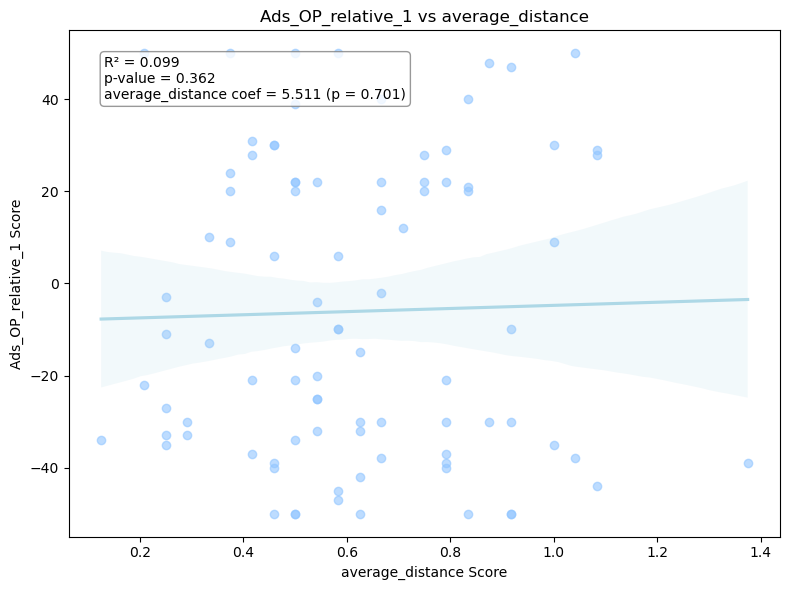


Regression results for Ads_CO_relative_1 (using average_distance):
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   40.4629     24.731      1.636      0.106      -8.743      89.669
average_distance        -0.2547     14.061     -0.018      0.986     -28.232      27.723
CO_distance_from_max     0.1740      4.843      0.036      0.971      -9.461       9.809
gender                  -6.3174      7.169     -0.881      0.381     -20.581       7.946
age                     -0.3207      0.308     -1.040      0.301      -0.934       0.293
education               -3.3938      3.648     -0.930      0.355     -10.652       3.864
race                    -3.7462      2.774     -1.351      0.181      -9.265       1.772
employment               1.4645      1.846      0.793      0.430      -2.209       5.138
income                  -1.2936      1.132

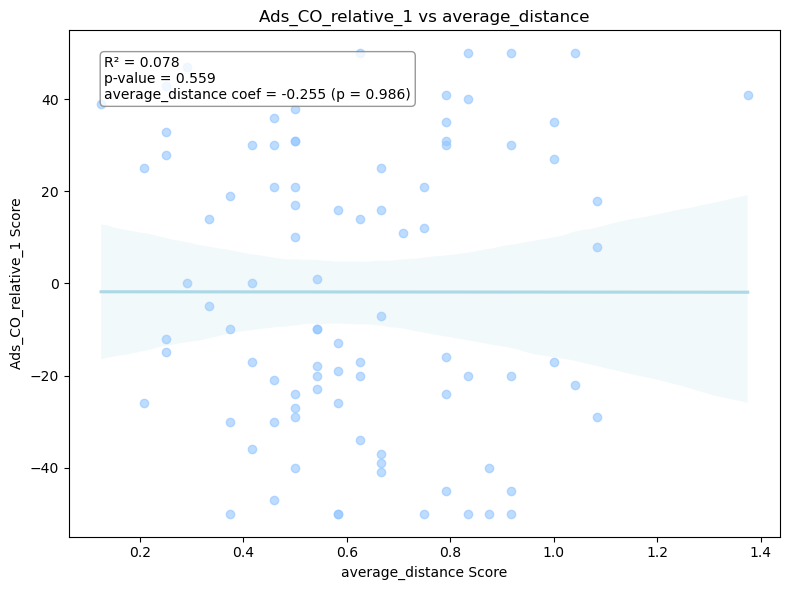


Regression results for Ads_EX_relative_1 (using average_distance):
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -25.6632     26.959     -0.952      0.344     -79.302      27.976
average_distance        29.6546     14.495      2.046      0.044       0.814      58.495
EX_distance_from_max     9.4917      4.358      2.178      0.032       0.820      18.164
gender                  -3.3028      7.622     -0.433      0.666     -18.469      11.863
age                     -0.2278      0.308     -0.740      0.461      -0.840       0.384
education               -0.0906      3.827     -0.024      0.981      -7.706       7.525
race                    -0.3421      2.929     -0.117      0.907      -6.170       5.486
employment               0.3212      1.942      0.165      0.869      -3.542       4.184
income                   0.7888      1.204

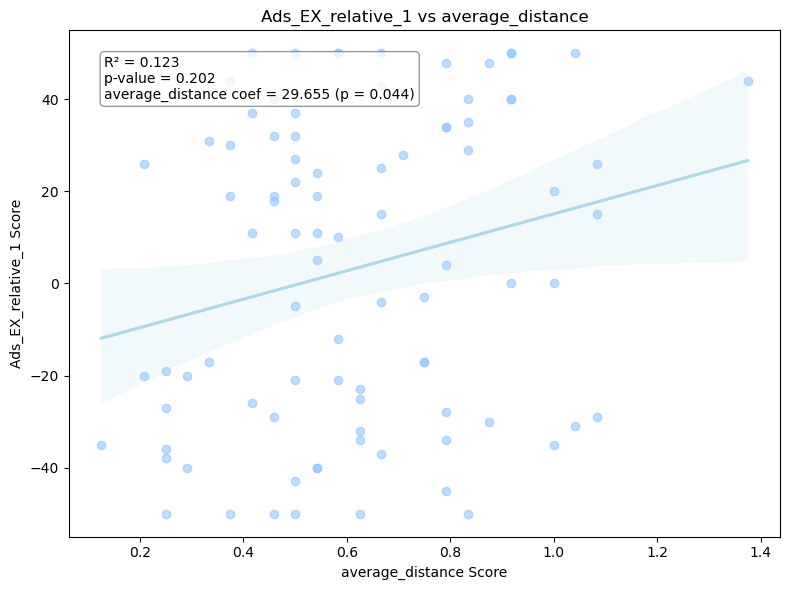


Regression results for Ads_AG_relative_1 (using average_distance):
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   13.2553     19.945      0.665      0.508     -26.429      52.939
average_distance         8.7193     11.990      0.727      0.469     -15.137      32.576
AG_distance_from_max    -2.5368      4.319     -0.587      0.559     -11.130       6.057
gender                  -9.2173      6.083     -1.515      0.134     -21.321       2.886
age                     -0.0223      0.244     -0.092      0.927      -0.507       0.463
education                3.2740      3.125      1.048      0.298      -2.943       9.491
race                    -3.0362      2.361     -1.286      0.202      -7.733       1.661
employment              -1.0284      1.590     -0.647      0.520      -4.192       2.136
income                   0.9135      0.965

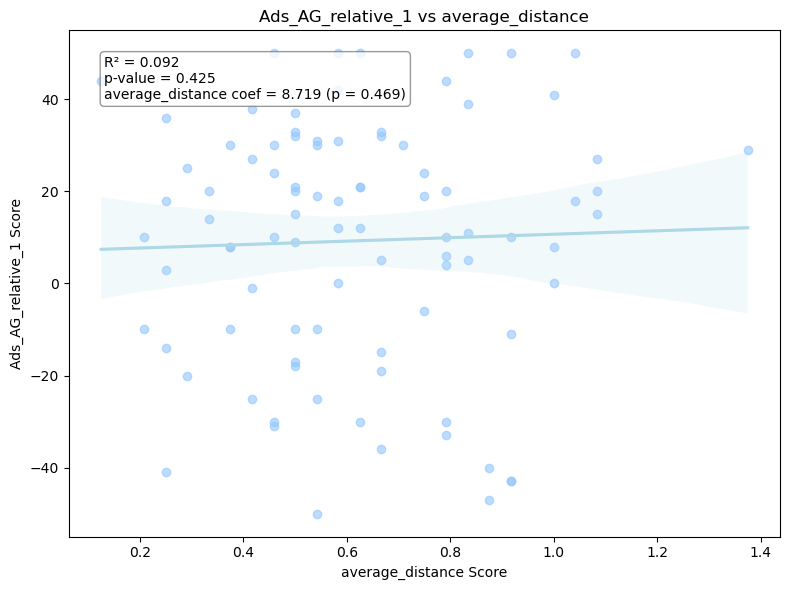

In [35]:
# (DV)         Ads_{trait type}_relative_1 
# (primary IV) average_distance

traits = ['OP', 'CO', 'EX', 'AG']

for trait in traits:
    # Prepare the data
    X = stmd_merged_df[['average_distance', 
                        '{}_distance_from_max'.format(trait),
                        'gender', 'age', 'education', 'race', 'employment', 'income']]
    y = stmd_merged_df['Ads_{}_relative_1'.format(trait)]
    
    # Add constant term to the features
    X = sm.add_constant(X)
    
    # Fit the model
    model = sm.OLS(y, X).fit()
    
    # Print the summary
    print(f"\nRegression results for Ads_{trait}_relative_1 (using average_distance):")
    print(model.summary().tables[1])
    
    # Create scatter plot
    plt.figure(figsize=(8, 6))
    sns.regplot(x='average_distance', 
                y='Ads_{}_relative_1'.format(trait), 
                data=stmd_merged_df, 
                scatter_kws={'alpha': 0.6},
                line_kws={'color': 'lightblue'})
    
    plt.title(f'Ads_{trait}_relative_1 vs average_distance')
    plt.xlabel('average_distance Score')
    plt.ylabel(f'Ads_{trait}_relative_1 Score')
    
    # Add annotations
    coef = model.params['average_distance']
    p_value = model.pvalues['average_distance']
    r_squared = model.rsquared
    f_pvalue = model.f_pvalue
    
    annotation = f"R² = {r_squared:.3f}\np-value = {f_pvalue:.3f}\naverage_distance coef = {coef:.3f} (p = {p_value:.3f})"
    plt.annotate(annotation, xy=(0.05, 0.95), xycoords='axes fraction',
                 ha='left', va='top',
                 bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()


Regression results for Ads_OP_relative_1:
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.6111     22.736      0.247      0.806     -39.617      50.839
Desc_OP_relative_1     0.2877      0.122      2.354      0.021       0.045       0.531
gender                -8.1395      7.071     -1.151      0.253     -22.207       5.928
age                   -0.1239      0.289     -0.428      0.670      -0.699       0.452
education             -3.1112      3.635     -0.856      0.395     -10.342       4.120
race                   2.7014      2.803      0.964      0.338      -2.874       8.277
employment            -0.2187      1.897     -0.115      0.909      -3.993       3.556
income                 1.6223      1.169      1.388      0.169      -0.703       3.948


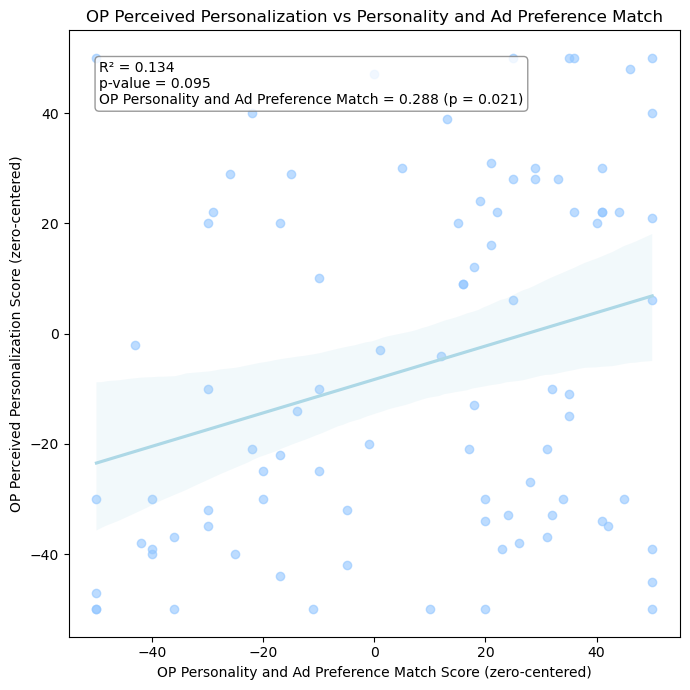


Regression Assumption Checks for OP:
Rainbow test for linearity - statistic: 1.4640, p-value: 0.1178
Durbin-Watson statistic: 1.9932
Breusch-Pagan test p-value: 0.0437

Number of influential points (Cook's distance > 4/n): 2
Shapiro-Wilk test p-value: 0.0245


<Figure size 1000x800 with 0 Axes>

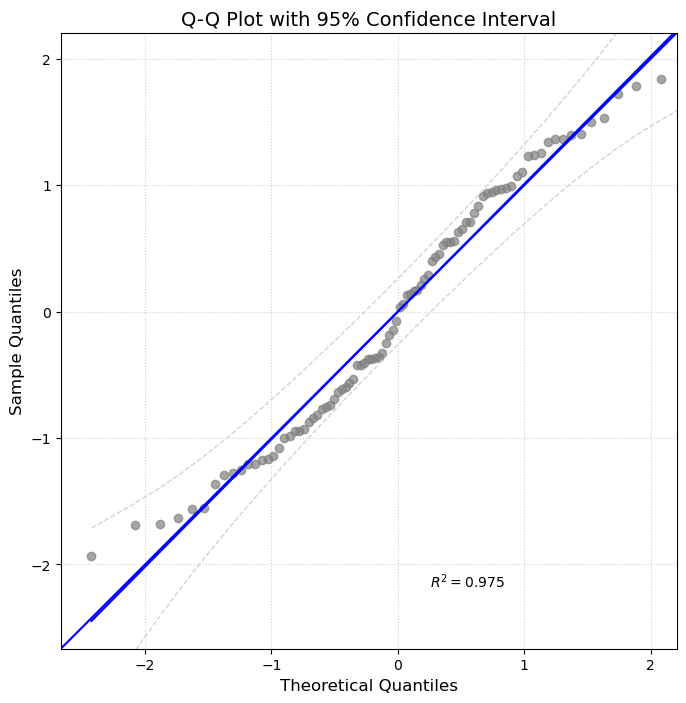


Variance Inflation Factors:
             Variable        VIF
0               const  48.524522
1  Desc_OP_relative_1   1.325029
2              gender   1.171264
3                 age   1.071625
4           education   1.441766
5                race   1.067668
6          employment   1.548139
7              income   1.422192

Maximum VIF: 48.5245 (Variable: const)

Regression results for Ads_CO_relative_1:
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 41.8352     22.281      1.878      0.064      -2.488      86.158
Desc_CO_relative_1     0.0611      0.110      0.557      0.579      -0.157       0.279
gender                -7.0492      7.175     -0.983      0.329     -21.322       7.224
age                   -0.3171      0.285     -1.111      0.270      -0.885       0.251
education             -3.4337      3.619     -0.949      0.346     -1

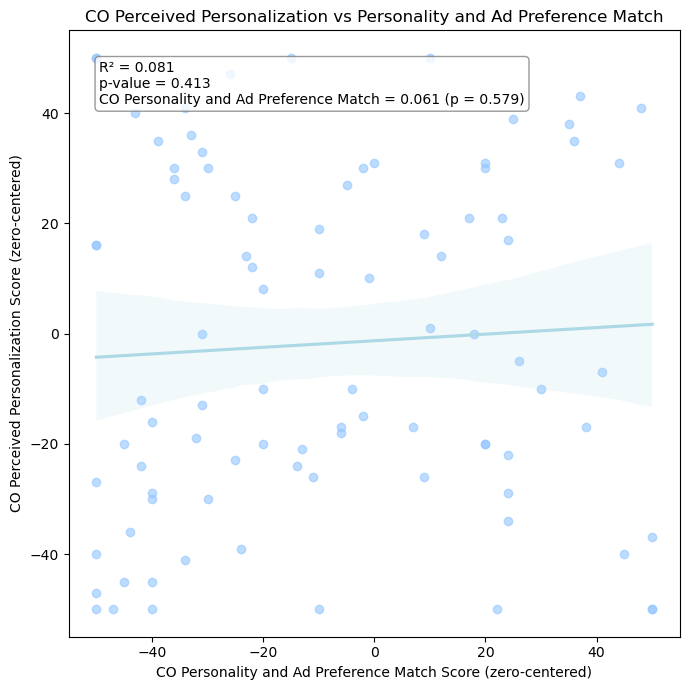


Regression Assumption Checks for CO:
Rainbow test for linearity - statistic: 0.9170, p-value: 0.6121
Durbin-Watson statistic: 1.9669
Breusch-Pagan test p-value: 0.7615

Number of influential points (Cook's distance > 4/n): 5
Shapiro-Wilk test p-value: 0.0192


<Figure size 1000x800 with 0 Axes>

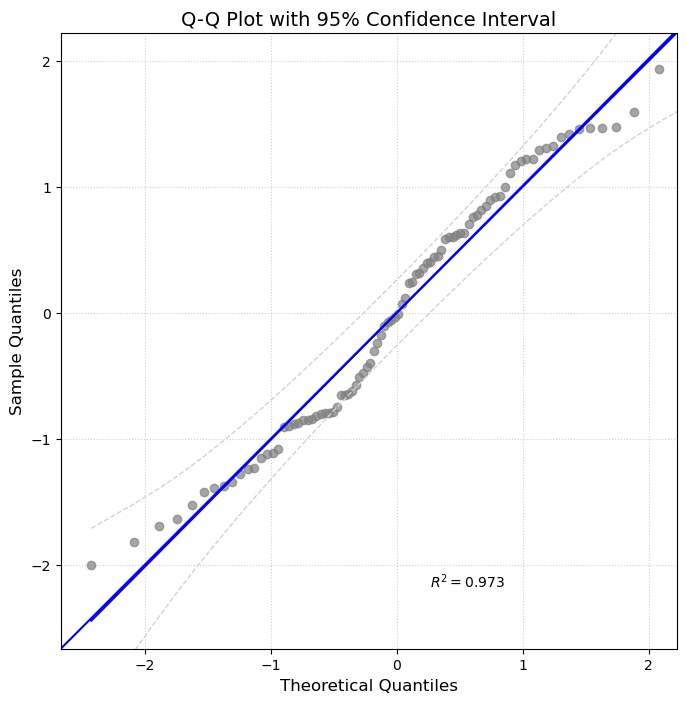


Variance Inflation Factors:
             Variable        VIF
0               const  46.440373
1  Desc_CO_relative_1   1.049872
2              gender   1.201522
3                 age   1.040051
4           education   1.424448
5                race   1.016185
6          employment   1.442115
7              income   1.314088

Maximum VIF: 46.4404 (Variable: const)

Regression results for Ads_EX_relative_1:
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 26.3422     24.849      1.060      0.292     -23.091      75.776
Desc_EX_relative_1     0.3048      0.160      1.904      0.060      -0.014       0.623
gender                -1.3156      7.839     -0.168      0.867     -16.910      14.279
age                   -0.4767      0.326     -1.462      0.148      -1.125       0.172
education             -1.1787      3.971     -0.297      0.767      -

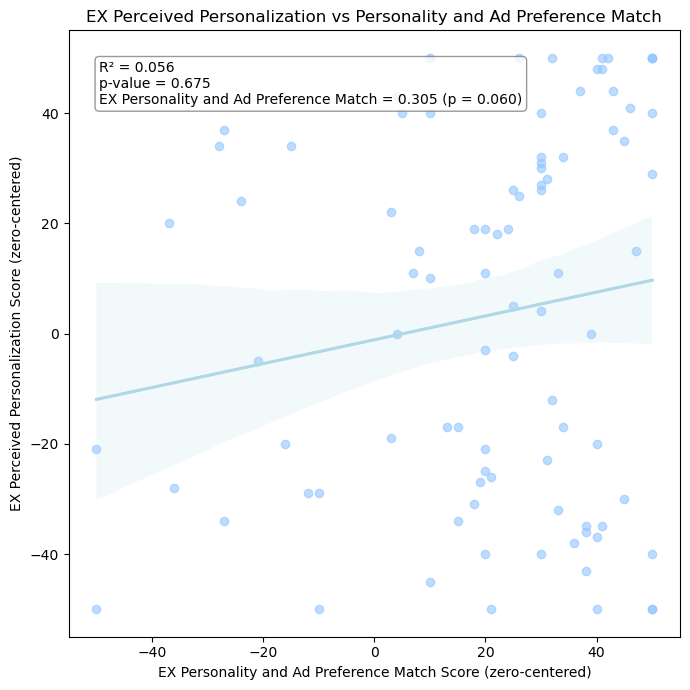


Regression Assumption Checks for EX:
Rainbow test for linearity - statistic: 1.1212, p-value: 0.3627
Durbin-Watson statistic: 1.7877
Breusch-Pagan test p-value: 0.2116

Number of influential points (Cook's distance > 4/n): 4
Shapiro-Wilk test p-value: 0.0007


<Figure size 1000x800 with 0 Axes>

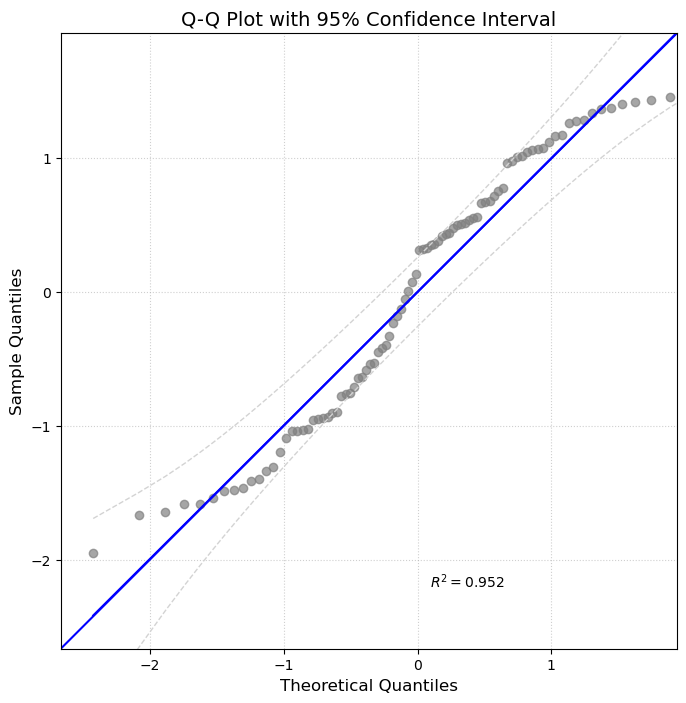


Variance Inflation Factors:
             Variable        VIF
0               const  48.620749
1  Desc_EX_relative_1   1.175253
2              gender   1.207313
3                 age   1.141928
4           education   1.443203
5                race   1.021093
6          employment   1.438209
7              income   1.292476

Maximum VIF: 48.6207 (Variable: const)

Regression results for Ads_AG_relative_1:
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 13.6869     19.456      0.703      0.484     -25.018      52.392
Desc_AG_relative_1    -0.0302      0.102     -0.298      0.767      -0.232       0.172
gender                -8.5601      6.024     -1.421      0.159     -20.544       3.423
age                    0.0226      0.251      0.090      0.929      -0.478       0.523
education              3.2106      3.189      1.007      0.317      -

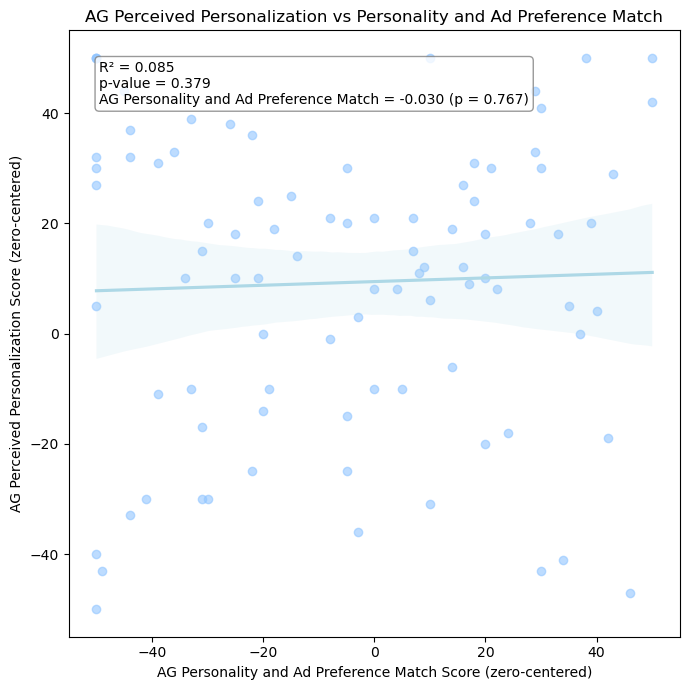


Regression Assumption Checks for AG:
Rainbow test for linearity - statistic: 1.1536, p-value: 0.3296
Durbin-Watson statistic: 1.8962
Breusch-Pagan test p-value: 0.0822

Number of influential points (Cook's distance > 4/n): 11
Shapiro-Wilk test p-value: 0.0918


<Figure size 1000x800 with 0 Axes>

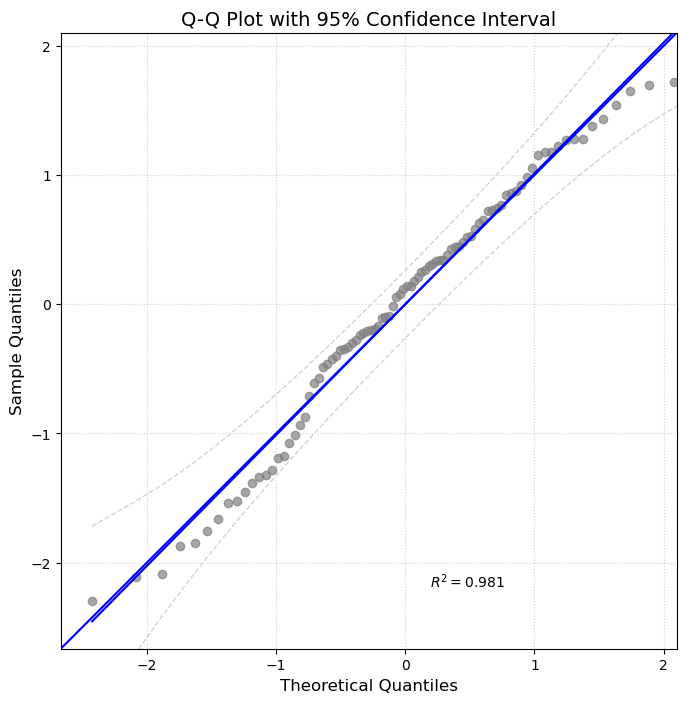


Variance Inflation Factors:
             Variable        VIF
0               const  49.373516
1  Desc_AG_relative_1   1.212528
2              gender   1.180901
3                 age   1.124718
4           education   1.541604
5                race   1.016247
6          employment   1.462656
7              income   1.305733

Maximum VIF: 49.3735 (Variable: const)


In [36]:
# (DV)          Ads_{trait type}_relative_1, 
# (primary IV) 	Desc_{trait type}_relative_1

traits = ['OP', 'CO', 'EX', 'AG']

for trait in traits:
    # Prepare the data
    X = stmd_merged_df[['Desc_{}_relative_1'.format(trait), 'gender', 'age', 'education', 'race', 'employment', 'income']]
    y = stmd_merged_df['Ads_{}_relative_1'.format(trait)]
    
    # Add constant term to the features
    X = sm.add_constant(X)
    
    # Fit the model
    model = sm.OLS(y, X).fit()
    
    # Print the summary
    print(f"\nRegression results for Ads_{trait}_relative_1:")
    print(model.summary().tables[1])
    
    # Create scatter plot
    plt.figure(figsize=(7, 7))
    sns.regplot(x='Desc_{}_relative_1'.format(trait), 
                y='Ads_{}_relative_1'.format(trait), 
                data=stmd_merged_df, 
                scatter_kws={'alpha': 0.6},
                line_kws={'color': 'lightblue'})
    
    plt.title(f'{trait} Perceived Personalization vs Personality and Ad Preference Match')
    plt.xlabel(f'{trait} Personality and Ad Preference Match Score (zero-centered)')
    plt.ylabel(f'{trait} Perceived Personalization Score (zero-centered)')
    
    # Add annotations
    coef = model.params['Desc_{}_relative_1'.format(trait)]
    p_value = model.pvalues['Desc_{}_relative_1'.format(trait)]
    r_squared = model.rsquared
    f_pvalue = model.f_pvalue
    
    annotation = f"R² = {r_squared:.3f}\np-value = {f_pvalue:.3f}\n{trait} Personality and Ad Preference Match = {coef:.3f} (p = {p_value:.3f})"
    plt.annotate(annotation, xy=(0.05, 0.95), xycoords='axes fraction',
                 ha='left', va='top',
                 bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

    # Check regression assumptions
    print(f"\nRegression Assumption Checks for {trait}:")
    assumption_results = check_regression_assumptions(model, X, y)
    

## H5.2: Personality Matching Effect - Reg Analysis between Trait Distances and Perceived Personalization Pattern 1-4

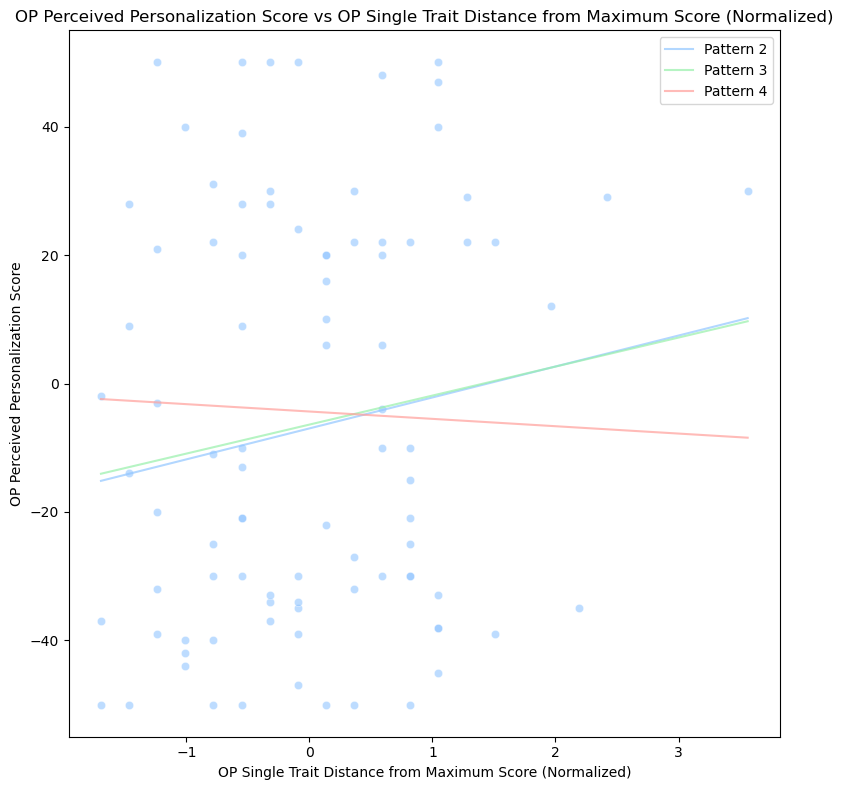

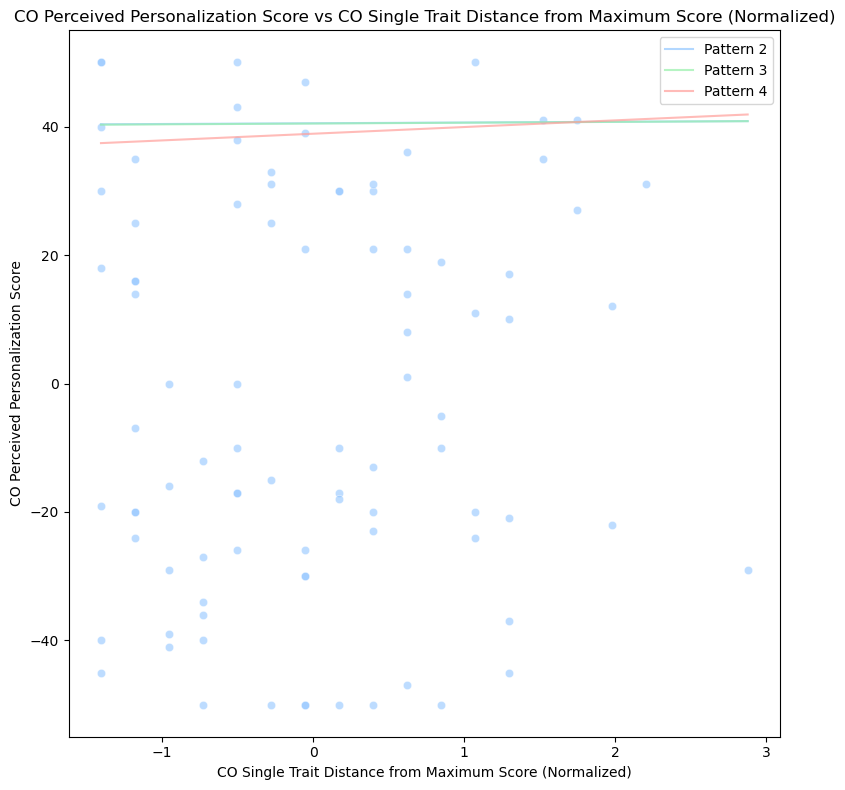

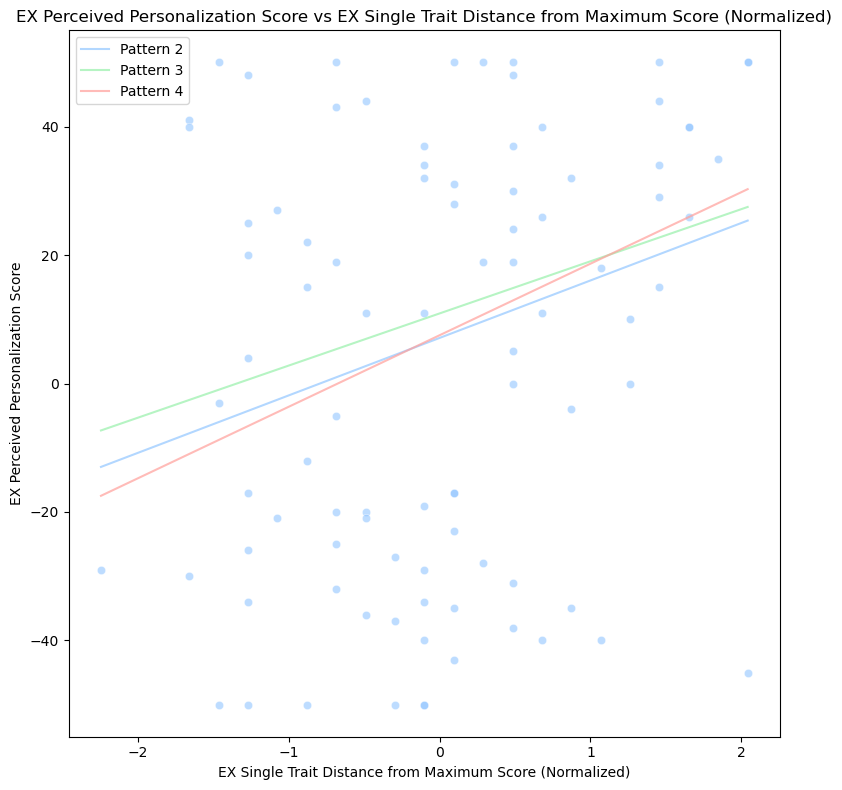

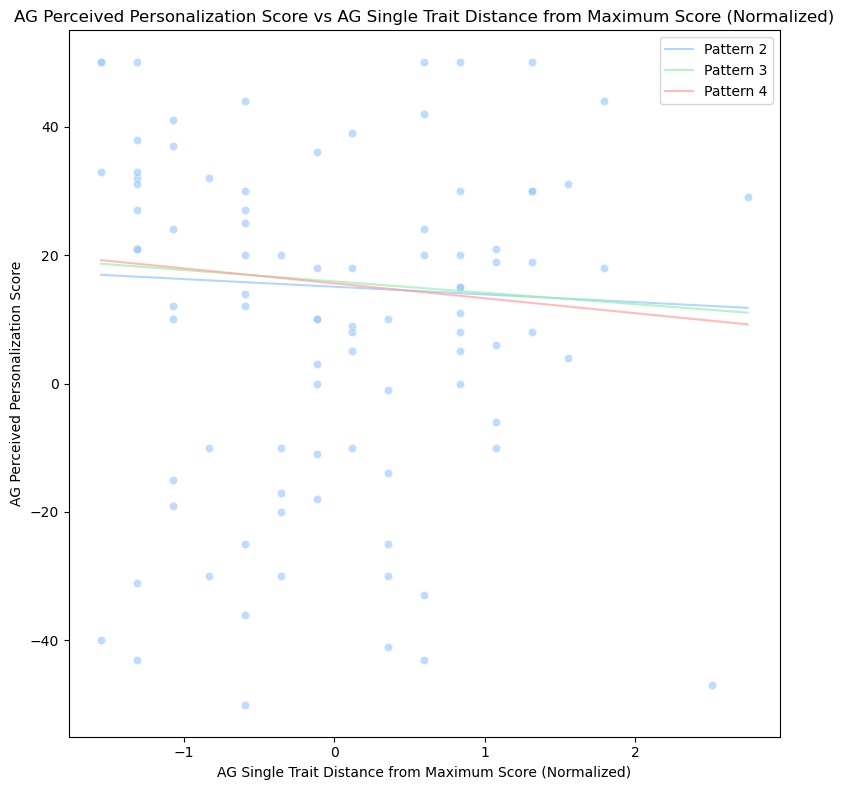


Summary for {}_distance_from_max:
                                      R2  Model_p  Primary_var_coef  Primary_var_p  Secondary_var_coef  Secondary_var_p  Interaction_coef  Interaction_p
Primary_var          Trait Pattern                                                                                                                      
OP_distance_from_max OP    2       0.098    0.277             4.821          0.165                 NaN              NaN               NaN            NaN
                           3       0.099    0.362             4.518          0.206               1.354            0.701               NaN            NaN
                           4       0.147    0.149            -1.145          0.794               2.465            0.481             7.555          0.036
CO_distance_from_max CO    2       0.078    0.446             0.115          0.974                 NaN              NaN               NaN            NaN
                           3       0.078    0.5

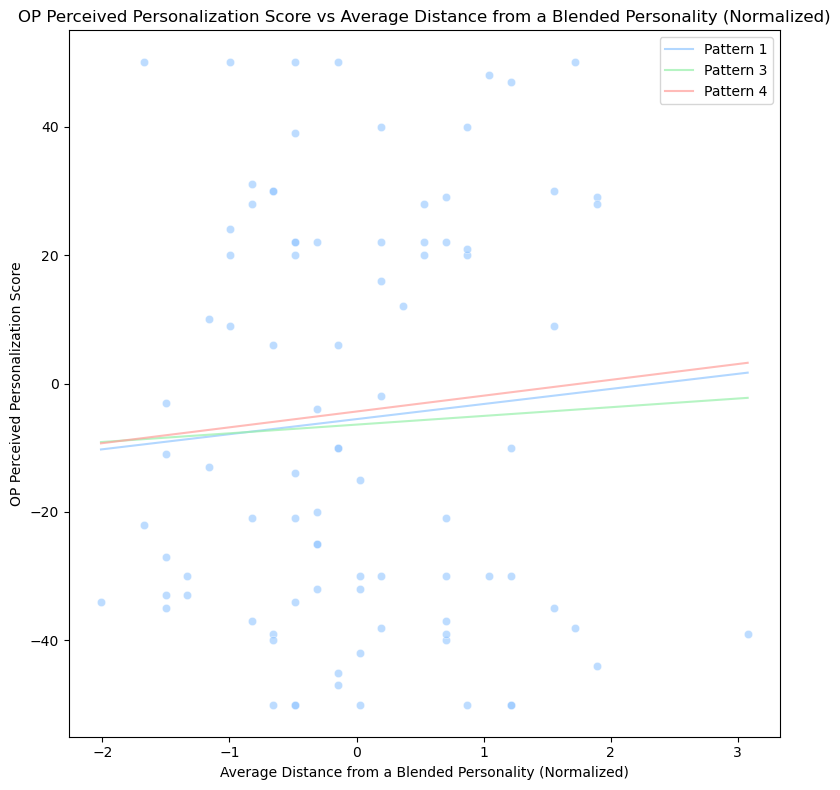

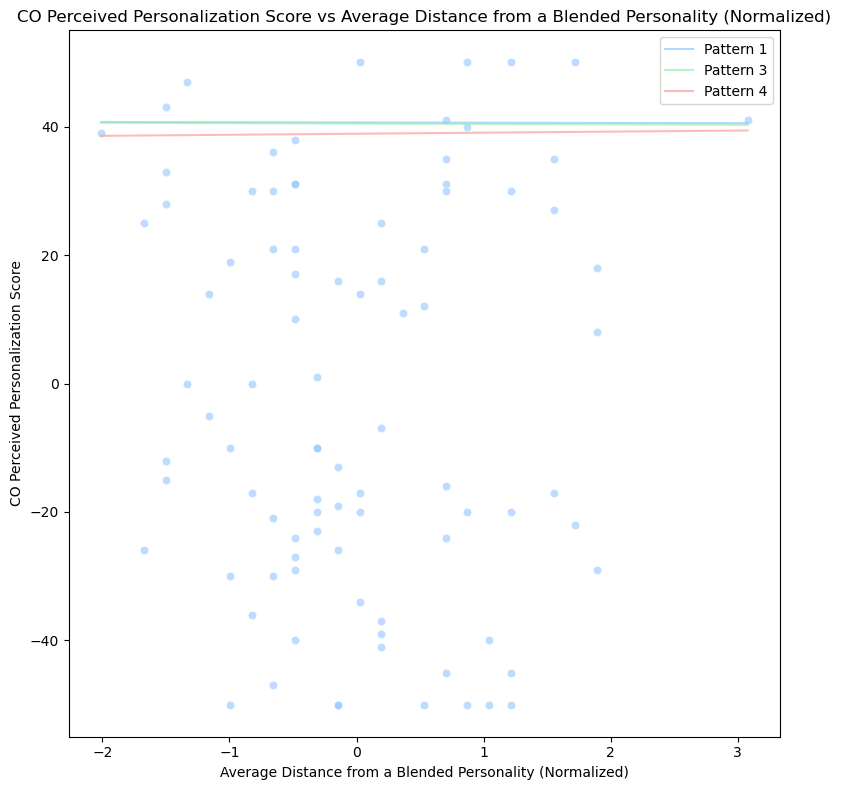

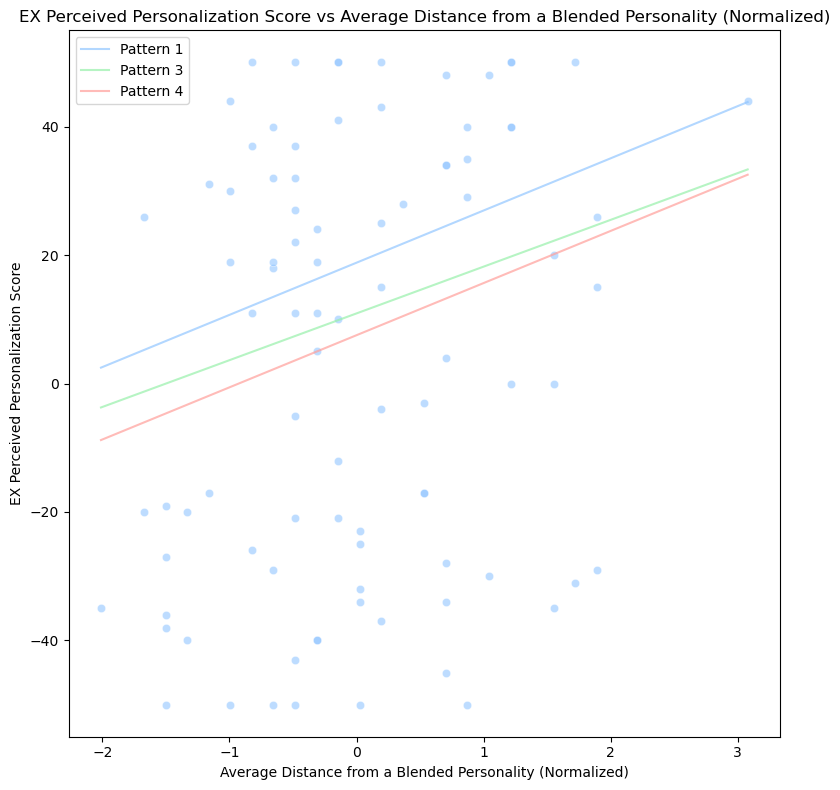

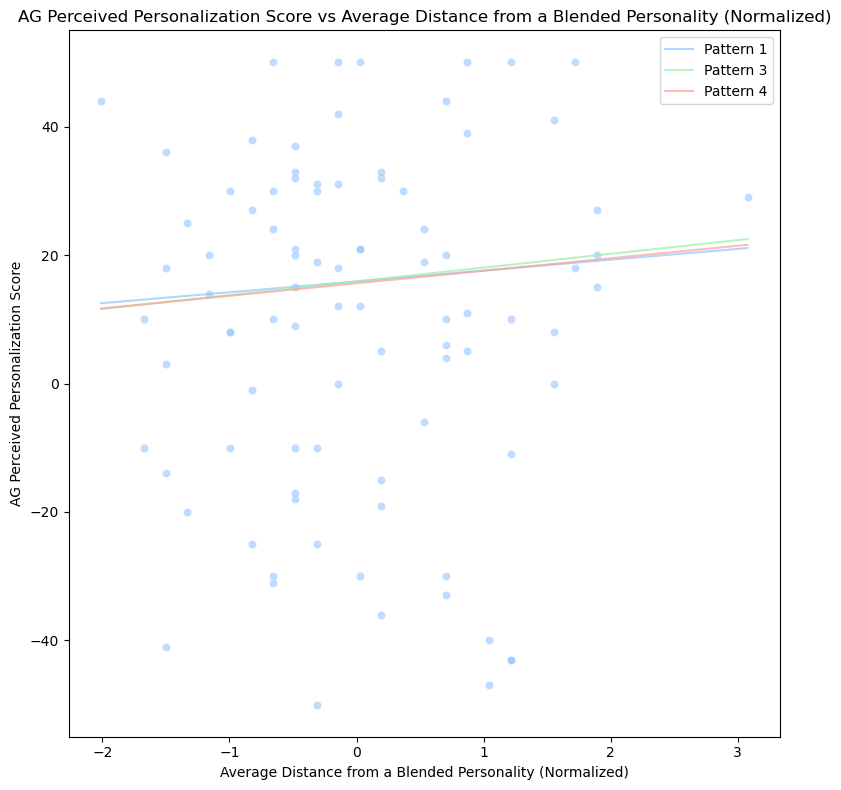


Summary for average_distance:
                                  R2  Model_p  Primary_var_coef  Primary_var_p  Secondary_var_coef  Secondary_var_p  Interaction_coef  Interaction_p
Primary_var      Trait Pattern                                                                                                                      
average_distance OP    1       0.081    0.414             2.351          0.497                 NaN              NaN               NaN            NaN
                       3       0.099    0.362             1.354          0.701               4.518            0.206               NaN            NaN
                       4       0.147    0.149             2.465          0.481              -1.145            0.794             7.555          0.036
                 CO    1       0.078    0.446            -0.036          0.991                 NaN              NaN               NaN            NaN
                       3       0.078    0.559            -0.063          0.

In [37]:
def run_analysis(primary_var):
    summary_data = []

    # Normalize all relevant variables once, outside the loop
    scaler = StandardScaler()
    for trait in traits:
        stmd_merged_df[f'{trait}_distance_from_max_normalized'] = scaler.fit_transform(stmd_merged_df[[f'{trait}_distance_from_max']])
    stmd_merged_df['average_distance_normalized'] = scaler.fit_transform(stmd_merged_df[['average_distance']])

    for trait in traits:
        # Create scatter plot (using normalized data)
        plt.figure(figsize=(8, 8))
        sns.scatterplot(x=f'{trait}_distance_from_max_normalized' if primary_var == '{}_distance_from_max' else 'average_distance_normalized', 
                        y='Ads_{}_relative_1'.format(trait), 
                        data=stmd_merged_df, 
                        alpha=0.6)

        # Add fitted lines for each pattern
        x_range = np.linspace(stmd_merged_df[f'{trait}_distance_from_max_normalized' if primary_var == '{}_distance_from_max' else 'average_distance_normalized'].min(), 
                              stmd_merged_df[f'{trait}_distance_from_max_normalized' if primary_var == '{}_distance_from_max' else 'average_distance_normalized'].max(), 100)

        for pattern in range(1, 5):
            if (primary_var == '{}_distance_from_max' and pattern == 1) or (primary_var == 'average_distance' and pattern == 2):
                continue  # Skip inappropriate patterns

            # Prepare the data for this specific pattern
            if pattern == 1:  # Only for average_distance
                X = stmd_merged_df[['average_distance_normalized', 'gender', 'age', 'education', 'race', 'employment', 'income']]
            elif pattern == 2:  # Only for {}_distance_from_max
                X = stmd_merged_df[[f'{trait}_distance_from_max_normalized', 'gender', 'age', 'education', 'race', 'employment', 'income']]
            elif pattern in [3, 4]:  # Same for both scenarios
                X = stmd_merged_df[[f'{trait}_distance_from_max_normalized', 'average_distance_normalized', 'gender', 'age', 'education', 'race', 'employment', 'income']]
                if pattern == 4:
                    X['{}_distance_x_avg_distance'.format(trait)] = X[f'{trait}_distance_from_max_normalized'] * X['average_distance_normalized']

            y = stmd_merged_df['Ads_{}_relative_1'.format(trait)]
            
            # Add constant term to the features
            X = sm.add_constant(X)
            
            # Fit the model
            model = sm.OLS(y, X).fit()
            
            # Store results
            primary_var_name = f'{trait}_distance_from_max_normalized' if primary_var == '{}_distance_from_max' else 'average_distance_normalized'
            summary_data.append({
                'Primary_var': primary_var.format(trait) if primary_var == '{}_distance_from_max' else primary_var,
                'Trait': trait,
                'Pattern': pattern,
                'R2': model.rsquared,
                'Model_p': model.f_pvalue,
                'Primary_var_coef': model.params.get(primary_var_name, np.nan),
                'Primary_var_p': model.pvalues.get(primary_var_name, np.nan),
                'Secondary_var_coef': model.params.get('average_distance_normalized' if primary_var == '{}_distance_from_max' else f'{trait}_distance_from_max_normalized', np.nan),
                'Secondary_var_p': model.pvalues.get('average_distance_normalized' if primary_var == '{}_distance_from_max' else f'{trait}_distance_from_max_normalized', np.nan),
                'Interaction_coef': model.params.get('{}_distance_x_avg_distance'.format(trait), np.nan),
                'Interaction_p': model.pvalues.get('{}_distance_x_avg_distance'.format(trait), np.nan)
            })

            # Calculate predicted values
            if pattern == 1:  # Only for average_distance
                y_pred = model.params['average_distance_normalized'] * x_range + model.params['const']
            elif pattern == 2:  # Only for {}_distance_from_max
                y_pred = model.params[f'{trait}_distance_from_max_normalized'] * x_range + model.params['const']
            elif pattern in [3, 4]:  # Same for both scenarios
                primary_coef = model.params[primary_var_name]
                secondary_coef = model.params['average_distance_normalized' if primary_var == '{}_distance_from_max' else f'{trait}_distance_from_max_normalized']
                secondary_mean = stmd_merged_df['average_distance_normalized' if primary_var == '{}_distance_from_max' else f'{trait}_distance_from_max_normalized'].mean()
                
                y_pred = primary_coef * x_range + secondary_coef * secondary_mean + model.params['const']
                
                if pattern == 4:
                    interaction_coef = model.params['{}_distance_x_avg_distance'.format(trait)]
                    y_pred += interaction_coef * x_range * secondary_mean

            plt.plot(x_range, y_pred, label=f'Pattern {pattern}', alpha=0.7)

        title = f'{trait} Perceived Personalization Score vs '
        title += f'{trait} Single Trait Distance from Maximum Score (Normalized)' if primary_var == '{}_distance_from_max' else 'Average Distance from a Blended Personality (Normalized)'
        plt.title(title)

        xlabel = f'{trait} Single Trait Distance from Maximum Score (Normalized)' if primary_var == '{}_distance_from_max' else 'Average Distance from a Blended Personality (Normalized)'
        plt.xlabel(xlabel)

        plt.ylabel(f'{trait} Perceived Personalization Score')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Create and print the summary DataFrame
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.set_index(['Primary_var', 'Trait', 'Pattern'])
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    print(f"\nSummary for {primary_var}:")
    print(summary_df.to_string(float_format='{:.3f}'.format))

    return summary_df

# Run analysis for {}_distance_from_max
summary_df_distance = run_analysis('{}_distance_from_max')

# Run analysis for average_distance
summary_df_average = run_analysis('average_distance')

## H5.2: Beyond Personality Matching Effect

### Assessing Stronger Appeal

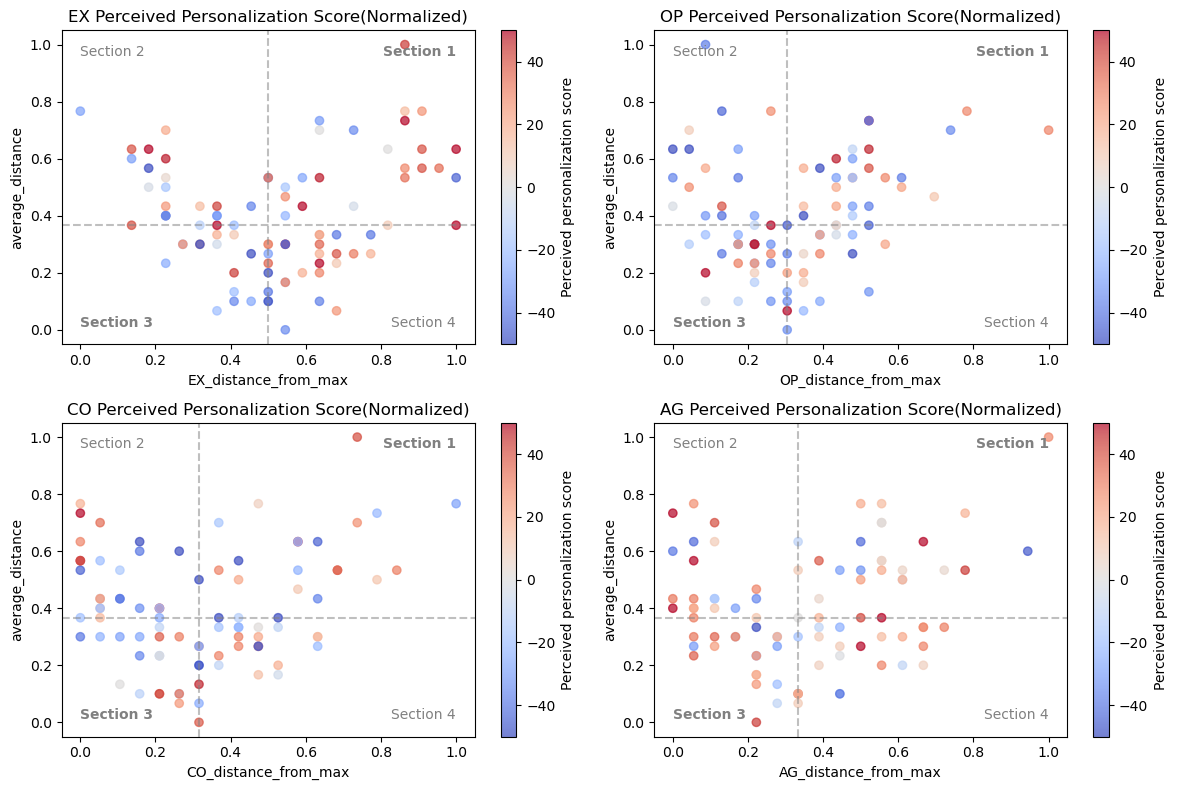

 Section                                                      Desc Trait  N   Mean   Preference              CI  t-statistics  p-value  Cohen's d
       1 High single trait distance, High blended average distance    AG 26   8.19      Blended  (-1.10, 17.53)          1.60   0.1225       0.32
       1 High single trait distance, High blended average distance    CO 27  -2.59 Single Trait  (-12.68, 6.47)         -0.45   0.6530      -0.09
       1 High single trait distance, High blended average distance    EX 26  -7.00 Single Trait  (-19.78, 5.08)         -1.10   0.2826      -0.22
       1 High single trait distance, High blended average distance    OP 32  -5.12 Single Trait  (-17.07, 6.79)         -0.87   0.3921      -0.16
       2  Low single trait distance, High blended average distance    AG 21  12.86      Blended   (3.63, 21.89)          2.48   0.0223       0.55
       2  Low single trait distance, High blended average distance    CO 20  -0.40 Single Trait  (-10.01, 8.60)         -0.0

In [38]:
def analyze_trait_bootstrap(traits, data, scaled="", n_bootstrap=10000):
    all_results = []
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.flatten()

    for idx, trait in enumerate(traits):
        x = data[f'{trait}_distance_from_max']
        y = data['average_distance']
        z = data[f'Ads_{trait}_relative_1']
        x_median = np.median(x)
        y_median = np.median(y)

        # 散布図
        scatter = axs[idx].scatter(x, y, c=z, cmap='coolwarm', alpha=0.7)
        axs[idx].grid(False)
        
        # セクション分割線の追加
        axs[idx].axvline(x_median, color='grey', linestyle='--', alpha=0.5)
        axs[idx].axhline(y_median, color='grey', linestyle='--', alpha=0.5)
        axs[idx].set_xlabel(f'{trait}_distance_from_max')
        axs[idx].set_ylabel('average_distance')
        axs[idx].set_title(f'{trait} Perceived Personalization Score{scaled}')
        plt.colorbar(scatter, ax=axs[idx], label='Perceived personalization score')

        # セクションの注釈を追加
        axs[idx].text(x.min(), y.max(), 'Section 2', ha='left', va='top', color='grey')
        axs[idx].text(x.max(), y.max(), 'Section 1', ha='right', va='top', color='grey', weight='bold')
        axs[idx].text(x.min(), y.min(), 'Section 3', ha='left', va='bottom', color='grey', weight='bold')
        axs[idx].text(x.max(), y.min(), 'Section 4', ha='right', va='bottom', color='grey')

        # セクションの定義と分析
        data['section'] = 2 * (y > y_median) + (x > x_median) + 1

        def bootstrap_analysis(scores):
            bootstrap_means = [np.mean(resample(scores, n_samples=len(scores))) for _ in range(n_bootstrap)]
            mean = np.mean(scores)
            ci = np.round(np.percentile(bootstrap_means, [2.5, 97.5]), 2)
            t_stat, p_value = stats.ttest_1samp(scores, 0)
            cohens_d = mean / np.std(scores)
            return mean, ci, t_stat, p_value, cohens_d

        for section in [1, 2, 3, 4]:
            section_data = data[data['section'] == section][f'Ads_{trait}_relative_1']
            mean, ci, t_stat, p_value, cohens_d = bootstrap_analysis(section_data)
            all_results.append({
                'Section': section,
                'Desc': {
                    1: 'High single trait distance, High blended average distance',
                    2: 'Low single trait distance, High blended average distance',
                    3: 'Low single trait distance, Low blended average distance',
                    4: 'High single trait distance, Low blended average distance'
                }[section],
                'Trait': trait,
                'N': len(section_data),
                'Mean': mean,
                'Preference': 'Blended' if mean > 0 else 'Single Trait',
                'CI': f"({ci[0]:.2f}, {ci[1]:.2f})",
                't-statistics': t_stat,
                'p-value': p_value,
                "Cohen's d": cohens_d
            })

    plt.tight_layout()
    plt.show()

    # 結果テーブルの作成と表示
    results_df = pd.DataFrame(all_results)
    results_df = results_df[['Section', 'Desc', 'Trait', 'N', 'Mean', 'Preference', 'CI', 't-statistics', 'p-value', "Cohen's d"]]
    results_df = results_df.sort_values(['Section', 'Trait'])
    results_df = results_df.round({'Mean': 2, 't-statistics': 2, 'p-value': 4, "Cohen's d": 2})
    print(results_df.to_string(index=False))

# 分析の実行
traits = ['EX', 'OP', 'CO', 'AG']
analyze_trait_bootstrap(traits, 
                        merged_df_norm, 
                        scaled="(Normalized)",
                        n_bootstrap=100)

### Assessing Wider Reach

Section Preference Analysis:
 Section Trait  N  Preference Rate  Binomial Test p-value
       1    AG 26           0.6538                 0.1686
       1    CO 27           0.3704                 0.2478
       1    EX 26           0.3846                 0.3269
       1    OP 32           0.3750                 0.2153
       2    AG 21           0.7143                 0.0784
       2    CO 20           0.5000                 1.0000
       2    EX 21           0.7143                 0.0784
       2    OP 15           0.4667                 1.0000
       3    AG 21           0.6190                 0.3833
       3    CO 23           0.4348                 0.6776
       3    EX 20           0.4500                 0.8238
       3    OP 16           0.3125                 0.2101
       4    AG 22           0.7273                 0.0525
       4    CO 20           0.5500                 0.8238
       4    EX 23           0.6087                 0.4049
       4    OP 27           0.5185         

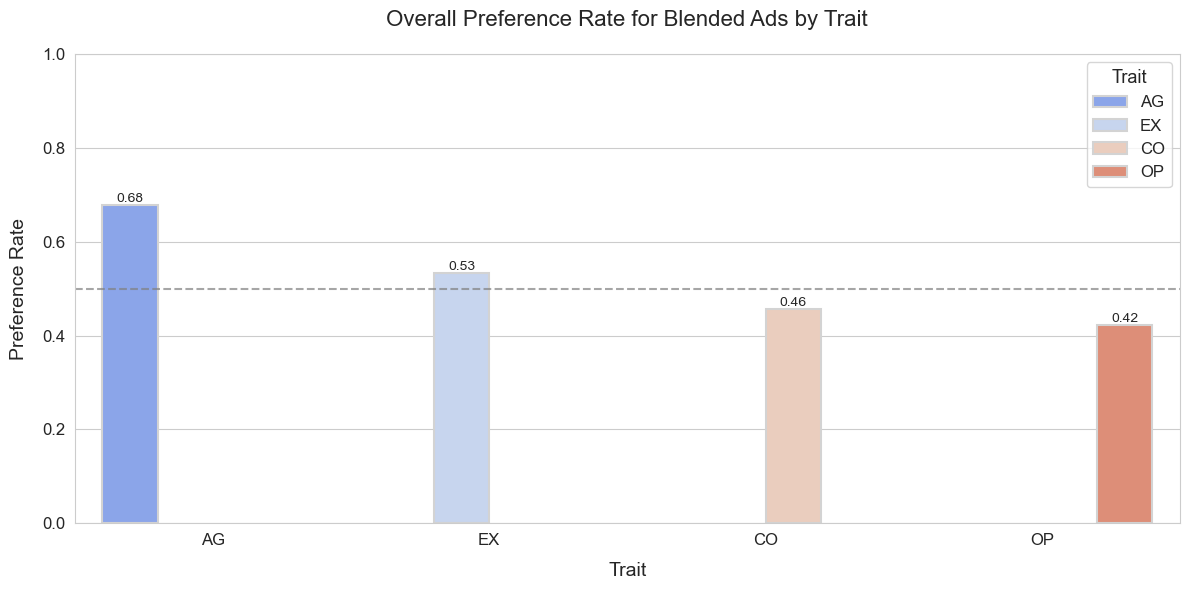

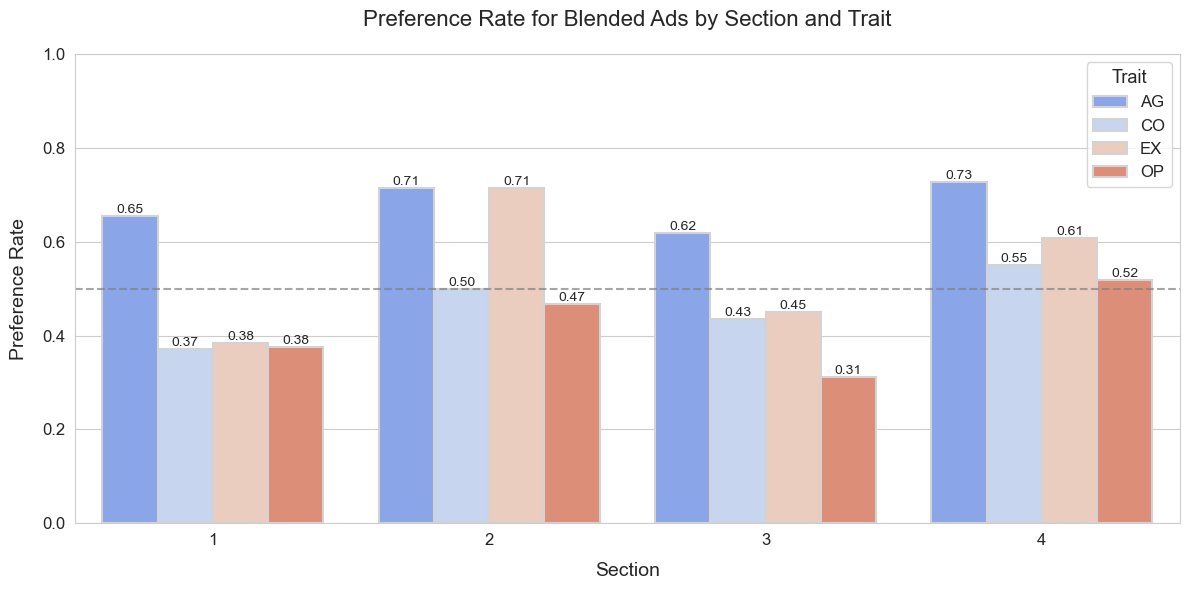

In [39]:
def analyze_trait_bootstrap(traits, data, scaled="", n_bootstrap=10000):
    section_preferences = []
    overall_preference = []

    for trait in traits:
        x = data[f'{trait}_distance_from_max']
        y = data['average_distance']
        z = data[f'Ads_{trait}_relative_1']
        x_median = np.median(x)
        y_median = np.median(y)

        # セクションの定義
        data['section'] = 2 * (y > y_median) + (x > x_median) + 1

        for section in [1, 2, 3, 4]:
            section_data = data[data['section'] == section][f'Ads_{trait}_relative_1']
            preference_rate = np.mean(section_data > 0)
            n_section = len(section_data)
            binom_p_value = stats.binom_test(int(preference_rate * n_section), n_section, p=0.5)
            
            section_preferences.append({
                'Section': section,
                'Trait': trait,
                'N': n_section,
                'Preference Rate': preference_rate,
                'Binomial Test p-value': binom_p_value
            })

        # Calculate overall preference
        trait_data = data[f'Ads_{trait}_relative_1']
        preference_rate = np.mean(trait_data > 0)
        binom_p_value = stats.binom_test(int(preference_rate * len(trait_data)), len(trait_data), p=0.5)
        overall_preference.append({
            'Trait': trait,
            'Preference Rate': preference_rate,
            'Binomial Test p-value': binom_p_value
        })

    # Create dataframes
    section_pref_df = pd.DataFrame(section_preferences)
    section_pref_df = section_pref_df.sort_values(['Section', 'Trait'])
    section_pref_df = section_pref_df.round({'Preference Rate': 4, 'Binomial Test p-value': 4})

    overall_pref_df = pd.DataFrame(overall_preference)
    overall_pref_df = overall_pref_df.sort_values('Preference Rate', ascending=False)
    overall_pref_df = overall_pref_df.round({'Preference Rate': 4, 'Binomial Test p-value': 4})

    # Print results
    print("Section Preference Analysis:")
    print(section_pref_df.to_string(index=False))
    print("\nOverall Preference for Blended Ads:")
    print(overall_pref_df.to_string(index=False))

    # Visualization function
    def plot_preference_rates(data, title, x_label):
        plt.figure(figsize=(12, 6))
        sns.set_style("whitegrid")
        bar_plot = sns.barplot(x=x_label, y='Preference Rate', hue='Trait', data=data, 
                               palette='coolwarm', edgecolor='lightgrey', linewidth=1.5)
        
        plt.title(title, fontsize=16, pad=20)
        plt.xlabel(x_label, fontsize=14, labelpad=10)
        plt.ylabel('Preference Rate', fontsize=14, labelpad=10)
        plt.ylim(0, 1)
        plt.axhline(0.5, color='gray', linestyle='--', alpha=0.7)
        
        for container in bar_plot.containers:
            bar_plot.bar_label(container, fmt='%.2f', label_type='edge')
        
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(title='Trait', title_fontsize='13', fontsize='12')
        plt.gca().set_facecolor('white')
        
        plt.tight_layout()
        plt.show()

    # Visualize overall preference
    plot_preference_rates(overall_pref_df, 'Overall Preference Rate for Blended Ads by Trait', 'Trait')

    # Visualize section preference
    plot_preference_rates(section_pref_df, 'Preference Rate for Blended Ads by Section and Trait', 'Section')

# 分析の実行
traits = ['EX', 'OP', 'CO', 'AG']
analyze_trait_bootstrap(traits, merged_df_norm, scaled="(Normalized)", n_bootstrap=10000)